In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import os
import numpy as np
from datetime import datetime, timedelta
import math
import orjson
from collections import Counter
from adjustText import adjust_text
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from concurrent.futures import ThreadPoolExecutor, as_completed

plt.rcParams["figure.figsize"] = [25, 10]

In [2]:
# Set list of test done
index_list_names = [
    "loadtest-webrtc-2024-kurento-2p",
    "loadtest-webrtc-2024-kurento-8p",
    "loadtest-webrtc-2024-kurento-3p-10s",
    "loadtest-webrtc-2024-kurento-3p-40s",
    "loadtest-webrtc-2024-pion-2p",
    "loadtest-webrtc-2024-pion-8p",
    "loadtest-webrtc-2024-pion-3p-10s",
    "loadtest-webrtc-2024-pion-3p-40s",
]

index_list_full_names = [
    "Kurento, 2 publishers per session",
    "Kurento, 8 publishers per session",
    "Kurento, 3 publishers and 10 subscribers per session",
    "Kurento, 3 publishers and 40 subscribers per session",
    "Pion, 2 publishers per session",
    "Pion, 8 publishers per session",
    "Pion, 3 publishers and 10 subscribers per session",
    "Pion, 3 publishers and 40 subscribers per session",
]  

In [3]:
# Helper functions
def read_file(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return orjson.loads(f.read())
    else:
        return []

def get_index_data(index_list_name, data_type):
    full_user_data = []

    for entry in os.scandir(f'stats/{index_list_name}'):
        if entry.is_dir():
            for sub_entry in os.scandir(entry.path):
                if sub_entry.is_dir():
                    data_path = os.path.join(sub_entry.path, data_type + '.json')
                    if os.path.exists(data_path):
                        data = read_file(data_path)
                        full_user_data.append({
                            'user': sub_entry.name,
                            'session': entry.name,
                            data_type: data
                        })
    return full_user_data


def is_publisher(index, user):
    return ("8p" in index) or (user <= 3)

def process_user_data(user_data):
    data = []
    for user in user_data:
        for event in user['events']:
            data.append({
                'user': int(user['user'].replace("User", "")),
                'session': int(user['session'].replace("LoadTestSession", "")),
                'event': event['event'] + (f"-{event['connection']}" if 'connection' in event else ""),
                'connection': event['connection'] if 'connection' in event else None,
                'timestamp': event['timestamp'],
            })
    return data

def process_index_list(index_list_name):
    user_data = get_index_data(index_list_name, "events")
    data = process_user_data(user_data)
    events_df = pd.DataFrame(data)
    events_df['timestamp'] = pd.to_datetime(events_df['timestamp'])
    events_df = events_df.sort_values(by='timestamp')
    return index_list_name, events_df


In [4]:
# Read all events files and save relevant data in DataFrames
events_dfs = {}

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(process_index_list, index_list_name): index_list_name for index_list_name in index_list_names}
    for future in as_completed(futures):
        index_list_name, events_df = future.result()
        events_dfs[index_list_name] = events_df

In [5]:
# Read log file and get specific lines with regex to get the connection failures
import re
def process_log_file(log_file):
    regex = re.compile(r'(.*) ERROR .* Participant (.*) in session (.*) failed (\d+) times')
    date_format = "%Y-%m-%d %H:%M:%S.%f %z"
    failed_attempts = []
    
    with open(log_file, 'r') as f:
        for line in f:
            if 'Participant' in line:
                match = regex.search(line)
                if match:
                    failed_attempts.append({
                        'user': match.group(2).replace('User', ''),
                        'session': match.group(3).replace('LoadTestSession', ''),
                        'attempts': int(match.group(4)),  # Ensure attempts is an integer
                        'timestamp': datetime.strptime(match.group(1) + " +0200", date_format),
                        'full_user': f"{match.group(2).replace('User', '')}-{match.group(3).replace('LoadTestSession', '')}",
                    })
    return log_file, pd.DataFrame(failed_attempts)

failures = {}

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(process_log_file, f'logs/{index_list_name}.log'): index_list_name for index_list_name in index_list_names}
    for future in as_completed(futures):
        log_file, df = future.result()
        index_list_name = log_file.split('/')[-1].replace('.log', '')
        failures[index_list_name] = df

In [6]:
# For test purposes, paint all events in a timeline
# for test, events_df in events_dfs.items():
#     events_df = events_df.sort_values(by=["session", "user", "timestamp"])
#     fig, ax = plt.subplots()
#     event_types = events_df['event'].unique()
#     event_types.sort()
#     colors = mpl.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(event_types)))
#     event_color = dict(zip(event_types, colors))
#     y_labels = []
#     y_ticks = 0
#     for session in events_dfs[test]['session'].unique():
#         events_df_session = events_df[events_df['session'] == session]
#         for user in events_df_session['user'].unique():
#             events_df_user = events_df_session[events_df_session['user'] == user]
#             y_ticks += 1
#             y_pos = [y_ticks] * len(events_df_user)
#             ax.scatter(events_df_user['timestamp'], y_pos, c=[event_color[event] for event in events_df_user['event']])
#             y_labels.append(f'{user} - {session}')

#     # add legend
#     legend_labels = []
#     for event, color in event_color.items():
#         legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=event, markerfacecolor=color))
#     ax.legend(handles=legend_labels, loc='upper left')
#     fig.suptitle(f'{test}')
#     # y labels should be user - session
#     ax.set_yticks(range(1, y_ticks + 1))
#     ax.set_yticklabels(y_labels)


In [7]:
# For test purposes, paint all connection relevant events in a timeline
# for test in events_dfs.keys():
#     events_df = events_dfs[test]
#     events_df = events_df.sort_values(by=["session", "user", "timestamp"])
#     # events_df = events_df[
#     #     (events_df['event'] == 'connectionStart') |
#     #     # (events_df['event'] == 'signalConnected') |
#     #     # (events_df['event'] == 'connectedPublisher') |
#     #     ((events_df['event'] == 'streamCreated') & (events_df['connection'] == 'local')) |
#     #     ((events_df['event'] == 'streamDestroyed') & (events_df['connection'] == 'local')) |
#     #     (events_df['event'] == 'connectionEnd')
#     # ]
#     events_df = events_df[
#         ~(events_df['event'] == 'publisherStartSpeaking-local') & ~(events_df['event'] == 'publisherStopSpeaking-local') &
#         ~(events_df['event'] == 'accessAllowed-local')
#     ]
#     fig, ax = plt.subplots()
#     event_types = events_df['event'].unique()
#     event_types.sort()
#     colors = mpl.colormaps.get_cmap('tab20')(np.linspace(0, 1, len(event_types)))
#     event_color = dict(zip(event_types, colors))
#     y_labels = []
#     y_ticks = 0
#     for session in events_df['session'].unique():
#         events_df_session = events_df[events_df['session'] == session]
#         for user in events_df_session['user'].unique():
#             events_df_user = events_df_session[events_df_session['user'] == user]
#             y_ticks += 1
#             y_pos = [y_ticks] * len(events_df_user)
#             ax.scatter(events_df_user['timestamp'], y_pos, c=[event_color[event] for event in events_df_user['event']])
#             y_labels.append(f'{user} - {session}')


#     # add legend
#     legend_labels = []
#     for event, color in event_color.items():
#         legend_labels.append(plt.Line2D([0], [0], marker='o', color='w', label=event, markerfacecolor=color))
#     ax.legend(handles=legend_labels, loc='upper left')
#     fig.suptitle(f'{test}')
#     # y labels should be user - session
#     ax.set_yticks(range(1, y_ticks + 1))
#     ax.set_yticklabels(y_labels)

In [8]:
# Read all CPU data and save it in DataFrames
df_cpu_list = []
for index in index_list_names:
    df_cpu = pd.read_csv(f"dfs_final/{index}-medianode.csv")
    df_cpu = df_cpu.drop(columns=["memory"]).dropna()
    df_cpu["@timestamp"] = pd.to_datetime(df_cpu["@timestamp"], format="ISO8601")
    df_cpu_list.append(df_cpu)

In [9]:
# Read all QoE data and save it processed in DataFrames
index_qoe_df_list = []
for index in index_list_names:
    index_qoe_df = pd.DataFrame()
    for entry in os.scandir(f"qoe/{index}"):
        if entry.is_file():
            with open(f"qoe/{index}/{entry.name}", 'r') as f:
                qoe = orjson.loads(f.read())
            qoe_df = pd.DataFrame.from_dict(qoe)
            info = entry.name.split("_")[0].split("-")
            session = info[1]
            userRecording = info[2]
            userBeingRecorded = info[3]
            qoe_df["userRecording"] = userRecording
            qoe_df["userBeingRecorded"] = userBeingRecorded
            qoe_df["session"] = session
            if index_qoe_df.empty:
                index_qoe_df = qoe_df
            else:
                index_qoe_df = pd.concat([index_qoe_df, qoe_df])
    index_qoe_df_list.append(index_qoe_df)


seconds_per_fragment = 17
seconds_per_padding = 2
seconds_per_video = seconds_per_fragment - seconds_per_padding
def set_qoe_times(df, user_1_start_connection_time, user_2_start_connection_time):
    cut_index_0_time = 5 # recording stats 5 seconds after connection is successful
    max_time = max(user_1_start_connection_time, user_2_start_connection_time)
    time_fn = lambda cut_index: max_time + timedelta(seconds=(cut_index * seconds_per_fragment) + cut_index_0_time).total_seconds()
    df.loc[:, "timestamp"] = df["cut_index"].apply(time_fn)


In [10]:
# Read batches data
with open(f"dfs_final/batches.json", 'r') as f:
    batches = orjson.loads(f.read())

In [11]:
# Process events to get when users' connections started, when they connected to the session and when the connection failed, and how long it lasted
user_events_obj = {}

def get_connection_times(events):
    connection_times_recorded = []
    recorded_media_events = events[
        (events["event"] != "connectionStart") &
        (events["event"] != "connectionFail")
    ]
    for m, row in recorded_media_events.iterrows():
        timestamp = row["timestamp"]
        con_time = (timestamp - start_time).total_seconds()
        connection_times_recorded.append(con_time)
    return connection_times_recorded


def get_failure_times(events):
    connection_times_recorded = []
    recorded_media_events = events[
        events["event"] == "connectionFail"
    ]
    for m, row in recorded_media_events.iterrows():
        timestamp = row["timestamp"]
        con_time = (timestamp - start_time).total_seconds()
        connection_times_recorded.append(con_time)
    return connection_times_recorded

df_cpu_filtered_list = []
start_end_times = {}
for i, index_list_name in enumerate(index_list_names):
    #stats_df = get_index_data(index_list_name, "stats")
    events_df = events_dfs[index_list_name]
    events_df = events_df.sort_values(by=["session", "user", "timestamp"])
    start_time = events_df["timestamp"].min()
    end_time = events_df["timestamp"].max()
    test_duration = (end_time - start_time).total_seconds()
    start_end_times[index_list_name] = (start_time, end_time)
    cpu = df_cpu_list[i]
    cpu_filtered = cpu[(cpu["@timestamp"] >= start_time) & (cpu["@timestamp"] <= end_time)]
    cpu_filtered.loc[:, "@timestamp"] = cpu_filtered["@timestamp"].apply(lambda x: (x - start_time).total_seconds())
    cpu_filtered = cpu_filtered.sort_values(by="@timestamp")
    df_cpu_filtered_list.append(cpu_filtered)
    index_qoe_df = index_qoe_df_list[i]
    sessions = events_df["session"].unique()
    user_events_obj[index_list_name] = {}
    for session in sessions:
        users = events_df[events_df["session"] == session]["user"].unique()
        for user in users:
            full_user = f"{user}-{session}"
            user_events = events_df[
                (events_df["session"] == session) & (events_df["user"] == user)
            ]
            connection_starts = user_events[user_events["event"] == "connectionStart"]
            failures_user = failures[index_list_name][
                (failures[index_list_name]["full_user"] == full_user) &
                (failures[index_list_name]["timestamp"] >= start_time) &
                (failures[index_list_name]["timestamp"] <= end_time)
            ].copy()
            failures_user["event"] = "connectionFail"
            failures_user["recoverable"] = False
            if "kurento" in index_list_name:
                if is_publisher(index_list_name, user):
                    stream_created_locals = user_events[
                        user_events["event"] == "streamCreated-local"
                    ]
                    stream_playing_locals = user_events[
                        user_events["event"] == "streamPlaying-local"
                    ]
                else:
                    # we choose the first stream created as confirmation of media connection if the user is subscriber
                    stream_created_locals = user_events[
                        user_events["event"].str.startswith("streamCreated")
                    ]
                    stream_playing_locals = user_events[
                        user_events["event"].str.startswith("streamPlaying")
                    ]
                # combine connection starts and stream created locals and failures_user
                combined = pd.concat(
                    [
                        connection_starts,
                        stream_created_locals,
                        stream_playing_locals,
                        failures_user,
                    ]
                )
                # if there is more than one stream created and a stream playing, we only keep the first one (marks connection success)
                combined = combined.sort_values(by="timestamp")
                prev_row_event = ""
                for r, row in combined.iterrows():
                    is_prev_row_connected = prev_row_event.startswith("streamCreated") or prev_row_event.startswith("streamPlaying")
                    is_current_row_connected = row["event"].startswith("streamCreated") or row["event"].startswith("streamPlaying")
                    if is_prev_row_connected and is_current_row_connected:
                        combined = combined.drop(r)
                    prev_row_event = row["event"]
            else:
                reconnecting_events = user_events[user_events["event"].str.contains("Reconnecting")].copy()
                if not reconnecting_events.empty:
                    reconnecting_events["event"] = "connectionFail"
                    reconnecting_events["recoverable"] = True
                    failures_user = pd.concat([failures_user, reconnecting_events])
                # combine connection starts and stream created locals and failures_user
                if is_publisher(index_list_name, user):
                    stream_created_locals = user_events[
                        user_events["event"] == "LocalTrackPublished-local"
                    ]
                    stream_created_locals = stream_created_locals.sort_values(by="timestamp")
                    # The second one means the publisher has fully connected
                    stream_created_locals = stream_created_locals.iloc[::2, :]
                else:
                    # we choose the first stream created as confirmation of media connection if the user is subscriber
                    stream_created_locals = user_events[
                        user_events["event"].str.startswith("TrackSubscribed")
                    ]
                # combine connection starts and stream created locals and failures_user
                combined = pd.concat(
                    [connection_starts, stream_created_locals, failures_user]
                )
                combined = combined.sort_values(by="timestamp")
                for r, row in combined.iterrows():
                    is_prev_row_connected = prev_row_event.startswith("TrackSubscribed")
                    is_current_row_connected = row["event"].startswith("TrackSubscribed")
                    if is_prev_row_connected and is_current_row_connected:
                        combined = combined.drop(r)
                    prev_row_event = row["event"]
            index_qoe_df_filtered = index_qoe_df[
                (index_qoe_df["session"] == "LoadTestSession" + str(session)) &
                (index_qoe_df["userRecording"] == "User" + str(user))
            ].copy()
            index_qoe_df_filtered = index_qoe_df_filtered.sort_values(by="cut_index")
            user_events_obj[index_list_name][full_user] = {}
            user_events_obj[index_list_name][full_user]["combined"] = combined
            user_events_obj[index_list_name][full_user]["qoe"] = index_qoe_df_filtered
            user_events_obj[index_list_name][full_user]["user"] = user
            user_events_obj[index_list_name][full_user]["session"] = session

In [12]:
# Calculate the intervals of time when a user is connected
def get_connection_time_intervals(user_events, start_time, test_duration):
    connection_time_intervals = {}
    users = user_events.keys()
    for username in users:
        group = user_events[username]['combined'].copy()
        group["timestamp"] = group["timestamp"].apply(lambda x: (x - start_time).total_seconds())
        connection_success_times = group.loc[~((group['event'] == 'connectionFail') | (group['event'] == 'connectionStart'))]['timestamp']
        connection_fail_times = group.loc[group['event'] == 'connectionFail']['timestamp']

        intervals = []
        for success_time in connection_success_times:
            fail_time = connection_fail_times[connection_fail_times > success_time].min()
            if pd.isnull(fail_time):
                intervals.append((success_time, test_duration))
            else:
                intervals.append((success_time, min(fail_time, test_duration)))

        connection_time_intervals[username] = intervals

    return connection_time_intervals

def intersect_intervals(intervals1, intervals2):
    intersection = []
    for interval1 in intervals1:
        for interval2 in intervals2:
            start = max(interval1[0], interval2[0])
            end = min(interval1[1], interval2[1])
            # there is a wait time of 5 seconds before starting recording
            start += 5
            if start < end:
                intersection.append((start, end))
    return intersection

intersections = {}
connection_time_intervals = {}
for index_list_name in index_list_names:
    intersections[index_list_name] = {}
    start_time, end_time = start_end_times[index_list_name]
    test_duration = (end_time - start_time).total_seconds()
    connection_time_intervals_index = get_connection_time_intervals(user_events_obj[index_list_name], start_time, test_duration)
    connection_time_intervals[index_list_name] = connection_time_intervals_index
    usernames = list(connection_time_intervals_index.keys())
    for i in range(len(usernames)):
        for j in range(i + 1, len(usernames)):
            _, session1 = usernames[i].split("-")
            _, session2 = usernames[j].split("-")
            if session1 == session2:
                user1_intervals = connection_time_intervals_index[usernames[i]]
                user2_intervals = connection_time_intervals_index[usernames[j]]
                intersection = intersect_intervals(user1_intervals, user2_intervals)
                if not usernames[i] in intersections[index_list_name]:
                    intersections[index_list_name][usernames[i]] = {}
                intersections[index_list_name][usernames[i]][usernames[j]] = intersection
                if not usernames[j] in intersections[index_list_name]:
                    intersections[index_list_name][usernames[j]] = {}
                intersections[index_list_name][usernames[j]][usernames[i]] = intersection



In [13]:
# Process QoE data to get the start and end of each fragment of time a QoE value is recorded
def set_frag_start_end(index_qoe_df, bi_intersections, fragment_duration, indexes):
    if len(bi_intersections) > 0:
        start = bi_intersections[0][0]
        end = bi_intersections[0][1]
        set_frag_start_end_aux(index_qoe_df, bi_intersections, fragment_duration, indexes, start, end, 0, 0)

def set_frag_start_end_aux(index_qoe_df, bi_intersections, fragment_duration, indexes, start, end, inters_j, index_i):
    if index_i < len(indexes):
        index = indexes[index_i]
        frag_end_time = start + fragment_duration
        if frag_end_time < end or math.isclose(frag_end_time, end, rel_tol=1e-9):
            index_qoe_df.loc[index, "start"] = start
            index_qoe_df.loc[index, "end"] = frag_end_time
            index_qoe_df.loc[index, "fragment_duration"] = fragment_duration
            start = frag_end_time
            set_frag_start_end_aux(index_qoe_df, bi_intersections, fragment_duration, indexes, start, end, inters_j, index_i + 1)
        else:
            j = inters_j + 1
            if j < len(bi_intersections):
                start = bi_intersections[j][0]
                end = bi_intersections[j][1]
                set_frag_start_end_aux(index_qoe_df, bi_intersections, fragment_duration, indexes, start, end, j, index_i)
            else:
                index_qoe_df.loc[index, "start"] = start
                index_qoe_df.loc[index, "end"] = end
                index_qoe_df.loc[index, "fragment_duration"] = end - start
                set_frag_start_end_aux(index_qoe_df, bi_intersections, fragment_duration, indexes, start, end, inters_j, index_i + 1)

for idx, index_list_name in enumerate(index_list_names):
    idx_intersections = intersections[index_list_name]
    index_qoe_df = index_qoe_df_list[idx]
    index_qoe_df["session"] = index_qoe_df["session"].str.replace("LoadTestSession", "")
    index_qoe_df["userRecording"] = index_qoe_df["userRecording"].str.replace("User", "")
    index_qoe_df["userBeingRecorded"] = index_qoe_df["userBeingRecorded"].str.replace("User", "")
    index_qoe_df["full_user_recording"] = index_qoe_df["userRecording"] + "-" + index_qoe_df["session"]
    index_qoe_df["full_user_being_recorded"] = index_qoe_df["userBeingRecorded"] + "-" + index_qoe_df["session"]
    index_qoe_df = index_qoe_df.drop(columns=["userRecording", "userBeingRecorded", "session"]).reset_index(drop=True)
    # for user recording
    for full_user in idx_intersections.keys():
        qoe = index_qoe_df[index_qoe_df["full_user_recording"] == full_user]
        intersections_user = idx_intersections[full_user]
        # for user being recorded
        for full_user_being_recorded in intersections_user.keys():
            qoe_being_recorded = qoe.loc[index_qoe_df["full_user_being_recorded"] == full_user_being_recorded]
            bi_intersections = intersections_user[full_user_being_recorded]
            con_duration = 0
            for intersection in bi_intersections:
                con_duration += intersection[1] - intersection[0]
            max_cut_index = qoe_being_recorded["cut_index"].max() + 1
            fragment_duration = con_duration / max_cut_index
            set_frag_start_end(index_qoe_df, bi_intersections, fragment_duration, qoe_being_recorded.index)
    index_qoe_df_list[idx] = index_qoe_df

In [14]:
# Helper function for getting the average QoE values for a specific user and in which times
def avg_qoe_intervals(index_qoe_df, metric, user):
    qoe = index_qoe_df[index_qoe_df["full_user_recording"] == user]
    qoe = qoe.sort_values(by=["start"])
    qoe["start"] = qoe["start"].round(decimals=5)
    qoe["end"] = qoe["end"].round(decimals=5)
    times = set()
    for index, row in qoe.iterrows():
        times.add(row["start"])
        times.add(row["end"])
    times = sorted(times)
    sub_intervals = []
    for i in range(len(times) - 1):
        start = times[i]
        end = times[i + 1]
        overlapping = []
        for r, row in qoe.iterrows():
            if (row["start"] < end and row["end"] > start):
                overlapping.append(row[metric])
        if len(overlapping) > 0:
            avg_qoe = sum(overlapping) / len(overlapping)
            sub_intervals.append(([start, end], avg_qoe))
    return sub_intervals

In [15]:
# Paint the connection progression of all users in a test and save the relevant data to DataFrames
plt.rcParams["figure.figsize"] = [40, 35]

colors_list = ["black", "orange", "yellow", "green", "darkblue"]
bounds = [0.2, 0.4, 0.6, 0.8, 1.0]
norm_bounds = [(b - min(bounds)) / (max(bounds) - min(bounds) ) for b in bounds]
success_cmap = mcolors.LinearSegmentedColormap.from_list("success", list(zip(norm_bounds, colors_list)))
normalize = mcolors.Normalize(vmin=min(bounds), vmax=max(bounds))

connection_stats_global = pd.DataFrame()

def get_con_type(next_color):
    if next_color == "magenta":
        return "connectionStart"
    elif next_color == "indigo":
        return "connectionSuccess"
    elif next_color == "red":
        return "connectionFail"
    else:
        return "QOE"

def calc_stats(cpu_filtered, prev_time, current_time, prev_attempt, n_batch, user, session, full_user, next_color, connection_stats, qoe=None, qoe_metric=None):
    total_duration = current_time - prev_time
    cpu_subset = cpu_filtered[(cpu_filtered['@timestamp'] >= prev_time) & (cpu_filtered['@timestamp'] <= current_time)]
    con_type = get_con_type(next_color)
    stats = {
        "type": con_type,
        "start_time": prev_time,
        "end_time": current_time,
        "total_duration": total_duration,
        "attempt": prev_attempt,
        "batch": n_batch,
        "user": user,
        "session": session,
        "full_user": full_user
    }
    if con_type == "QOE":
        stats["qoe"] = qoe
        stats["qoe_metric"] = qoe_metric
    # if there is no cpu data, add the next cpu data available
    if cpu_subset.empty:
        # seek closest cpu data to start_time or end_time
        cpu_prev_df = cpu_filtered[cpu_filtered['@timestamp'] < prev_time]
        cpu_next_df = cpu_filtered[cpu_filtered['@timestamp'] > current_time]
        # if one of the dfs is empty, we take the other
        if cpu_prev_df.empty:
            cpu_next = cpu_next_df.iloc[0]
            cpu_subset = cpu_filtered[cpu_filtered['@timestamp'] == cpu_next['@timestamp']]
        elif cpu_next_df.empty:
            cpu_prev = cpu_prev_df.iloc[-1]
            cpu_subset = cpu_filtered[cpu_filtered['@timestamp'] == cpu_prev['@timestamp']]
        else:
            cpu_next = cpu_next_df.iloc[0]
            cpu_prev = cpu_prev_df.iloc[-1]
            cpu_prev_diff = prev_time - cpu_prev['@timestamp']
            cpu_next_diff = cpu_next['@timestamp'] - current_time
            if cpu_prev_diff < cpu_next_diff:
                cpu_subset = cpu_filtered[cpu_filtered['@timestamp'] == cpu_prev['@timestamp']]
            else:
                cpu_subset = cpu_filtered[cpu_filtered['@timestamp'] == cpu_next['@timestamp']]
    stats["cpu_mean"] = cpu_subset['cpu'].mean()
    stats["cpu_start"] = cpu_subset['cpu'].iloc[0]
    stats["cpu_end"] = cpu_subset['cpu'].iloc[-1]
    stats["cpu_median"] = cpu_subset['cpu'].median()
    stats["cpu_max"] = cpu_subset['cpu'].max()
    stats["cpu_min"] = cpu_subset['cpu'].min()
    connection_stats.append(stats)
    return connection_stats

def paint_bar(ax, prev_time, current_time, y_ticks, prev_state, next_color):
    total_duration = current_time - prev_time
    yrange = (y_ticks - 0.5, 0.8)
    if prev_state != "connectionSuccess":
        segment = [(prev_time, total_duration)]
        ax.broken_barh(segment, yrange, facecolors=next_color)

def paint_success_bar(ax, prev_time, current_time, y_ticks, qoe):
    total_duration = current_time - prev_time
    yrange = (y_ticks - 0.5, 0.8)
    segment = [(prev_time, total_duration)]
    color = success_cmap(qoe)
    ax.broken_barh(segment, yrange, facecolors=color)
    return color

def draw_cons_plot(i, index_list_name, metric):
    global connection_stats_global
    fig, ax = plt.subplots()
    y_labels = []
    y_ticks = 0
    user_count = 0
    connection_stats = []
    batch_info = batches[index_list_name]
    cpu_filtered = df_cpu_filtered_list[i]
    start_time, end_time = start_end_times[index_list_name]
    test_duration = (end_time - start_time).total_seconds()
    index_qoe_df = index_qoe_df_list[i]
    for full_user, full_user_obj in user_events_obj[index_list_name].items():
        user_count += 1
        if user_count <= batch_info["startingParticipants"]:
            n_batch = 0
        else:
            n_batch = math.floor((user_count - batch_info["startingParticipants"] - 1) / batch_info["batchSize"]) + 1
        user_split = full_user.split("-")
        user = user_split[0]
        session = user_split[1]
        y_labels.append(full_user)
        y_ticks += 1

        next_color = "white"
        prev_time = None
        prev_state = None
        prev_attempt = 0
        combined = full_user_obj["combined"]
        full_con_segments = connection_time_intervals[index_list_name][full_user]
        con_segments = avg_qoe_intervals(index_qoe_df, metric, full_user)
        # connection success
        for full_segment in full_con_segments:
            paint_bar(ax, full_segment[0], full_segment[1], y_ticks, "", "indigo")
            calc_stats(cpu_filtered, full_segment[0], full_segment[1], prev_attempt, n_batch, user, session, full_user, "indigo", connection_stats)
        for segment in con_segments:
            color = paint_success_bar(ax, segment[0][0], segment[0][1], y_ticks, segment[1])
            calc_stats(cpu_filtered, segment[0][0], segment[0][1], prev_attempt, n_batch, user, session, full_user, color, connection_stats, segment[1], metric)
        # other connection events
        for r, row in combined.iterrows():
            current_time = (row["timestamp"] - start_time).total_seconds()
            if prev_time is not None:
                paint_bar(ax, prev_time, current_time, y_ticks, prev_state, next_color)
                calc_stats(cpu_filtered, prev_time, current_time, prev_attempt, n_batch, user, session, full_user, next_color, connection_stats)
            connectionSuccessful = (
                row["event"].startswith("streamCreated")
                or row["event"].startswith("streamPlaying")
                or row["event"].startswith("LocalTrackPublished")
                or row["event"].startswith("TrackSubscribed")
            )
            if row["event"] == "connectionStart":
                next_color = "magenta"
                prev_state = "connectionStart"
            elif connectionSuccessful:
                next_color = "indigo"
                prev_state = "connectionSuccess"
            else:
                next_color = "red"
                prev_attempt = row["attempts"]
                prev_state = "connectionFail"
            prev_time = current_time
        if prev_time is not None:
            paint_bar(ax, prev_time, test_duration, y_ticks, prev_state, next_color)
            calc_stats(cpu_filtered, prev_time, test_duration, prev_attempt, n_batch, user, session, full_user, next_color, connection_stats)
    connection_stats_df = pd.DataFrame(connection_stats)
    # add all rows to connection_stats_global
    if connection_stats_global.empty:
        connection_stats_global = connection_stats_df
        connection_stats_global["index"] = index_list_name
    else:
        connection_stats_df["index"] = index_list_name
        connection_stats_global = pd.concat([connection_stats_global, connection_stats_df])

    ax.set_yticks(range(1, y_ticks + 1))
    ax.set_yticklabels(y_labels)
    ax.set_title(f"Connection Progression ({metric}) - {index_list_full_names[i]}", pad=10)
    # y axis label
    ax.set_ylabel("User - Session")
    if user_count >= 150:
        # remove y labels
        ax.set_yticklabels([])
    # x axis label
    ax.set_xlabel("Time (s)")
    ax.set_xlim(-5, test_duration + 5)
    # grid
    ax.grid(True)
    # x axis ticks every 10 seconds
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    # cpu in new axis
    ax2 = ax.twinx()
    ax2.set_ylabel("CPU (%)")
    # ax2 y axis should go from 0 to 1
    ax2.set_ylim(0, 1.01)
    ax2.set_yticks(np.arange(0, 1.01, 0.05))
    ax2.plot(cpu_filtered["@timestamp"], cpu_filtered["cpu"], color="black", marker="o", linewidth=4, markersize=10)
    # create legend
    legend_labels = [
        plt.Line2D([0], [0], color="magenta", lw=4, label="Connection Start"),
        plt.Line2D([0], [0], color="indigo", lw=4, label="Stream Created/Playing, No Video"),
        plt.Line2D([0], [0], color="darkblue", lw=4, label="Excellent QoE"),
        plt.Line2D([0], [0], color="green", lw=4, label="Good QoE"),
        plt.Line2D([0], [0], color="yellow", lw=4, label="Fair QoE"),
        plt.Line2D([0], [0], color="orange", lw=4, label="Poor QoE"),
        plt.Line2D([0], [0], color="black", lw=4, label="Bad QoE"),
        plt.Line2D([0], [0], color="red", lw=4, label="Failed Connection"),
        plt.Line2D([0], [0], color="black", lw=4, label="CPU", marker="o", markersize=10)
    ]

    ax.legend(handles=legend_labels, loc="upper left")
    fig.savefig(f"plots/connection_progression_{index_list_name[21:]}_{metric}.png", bbox_inches="tight")


KeyboardInterrupt: 

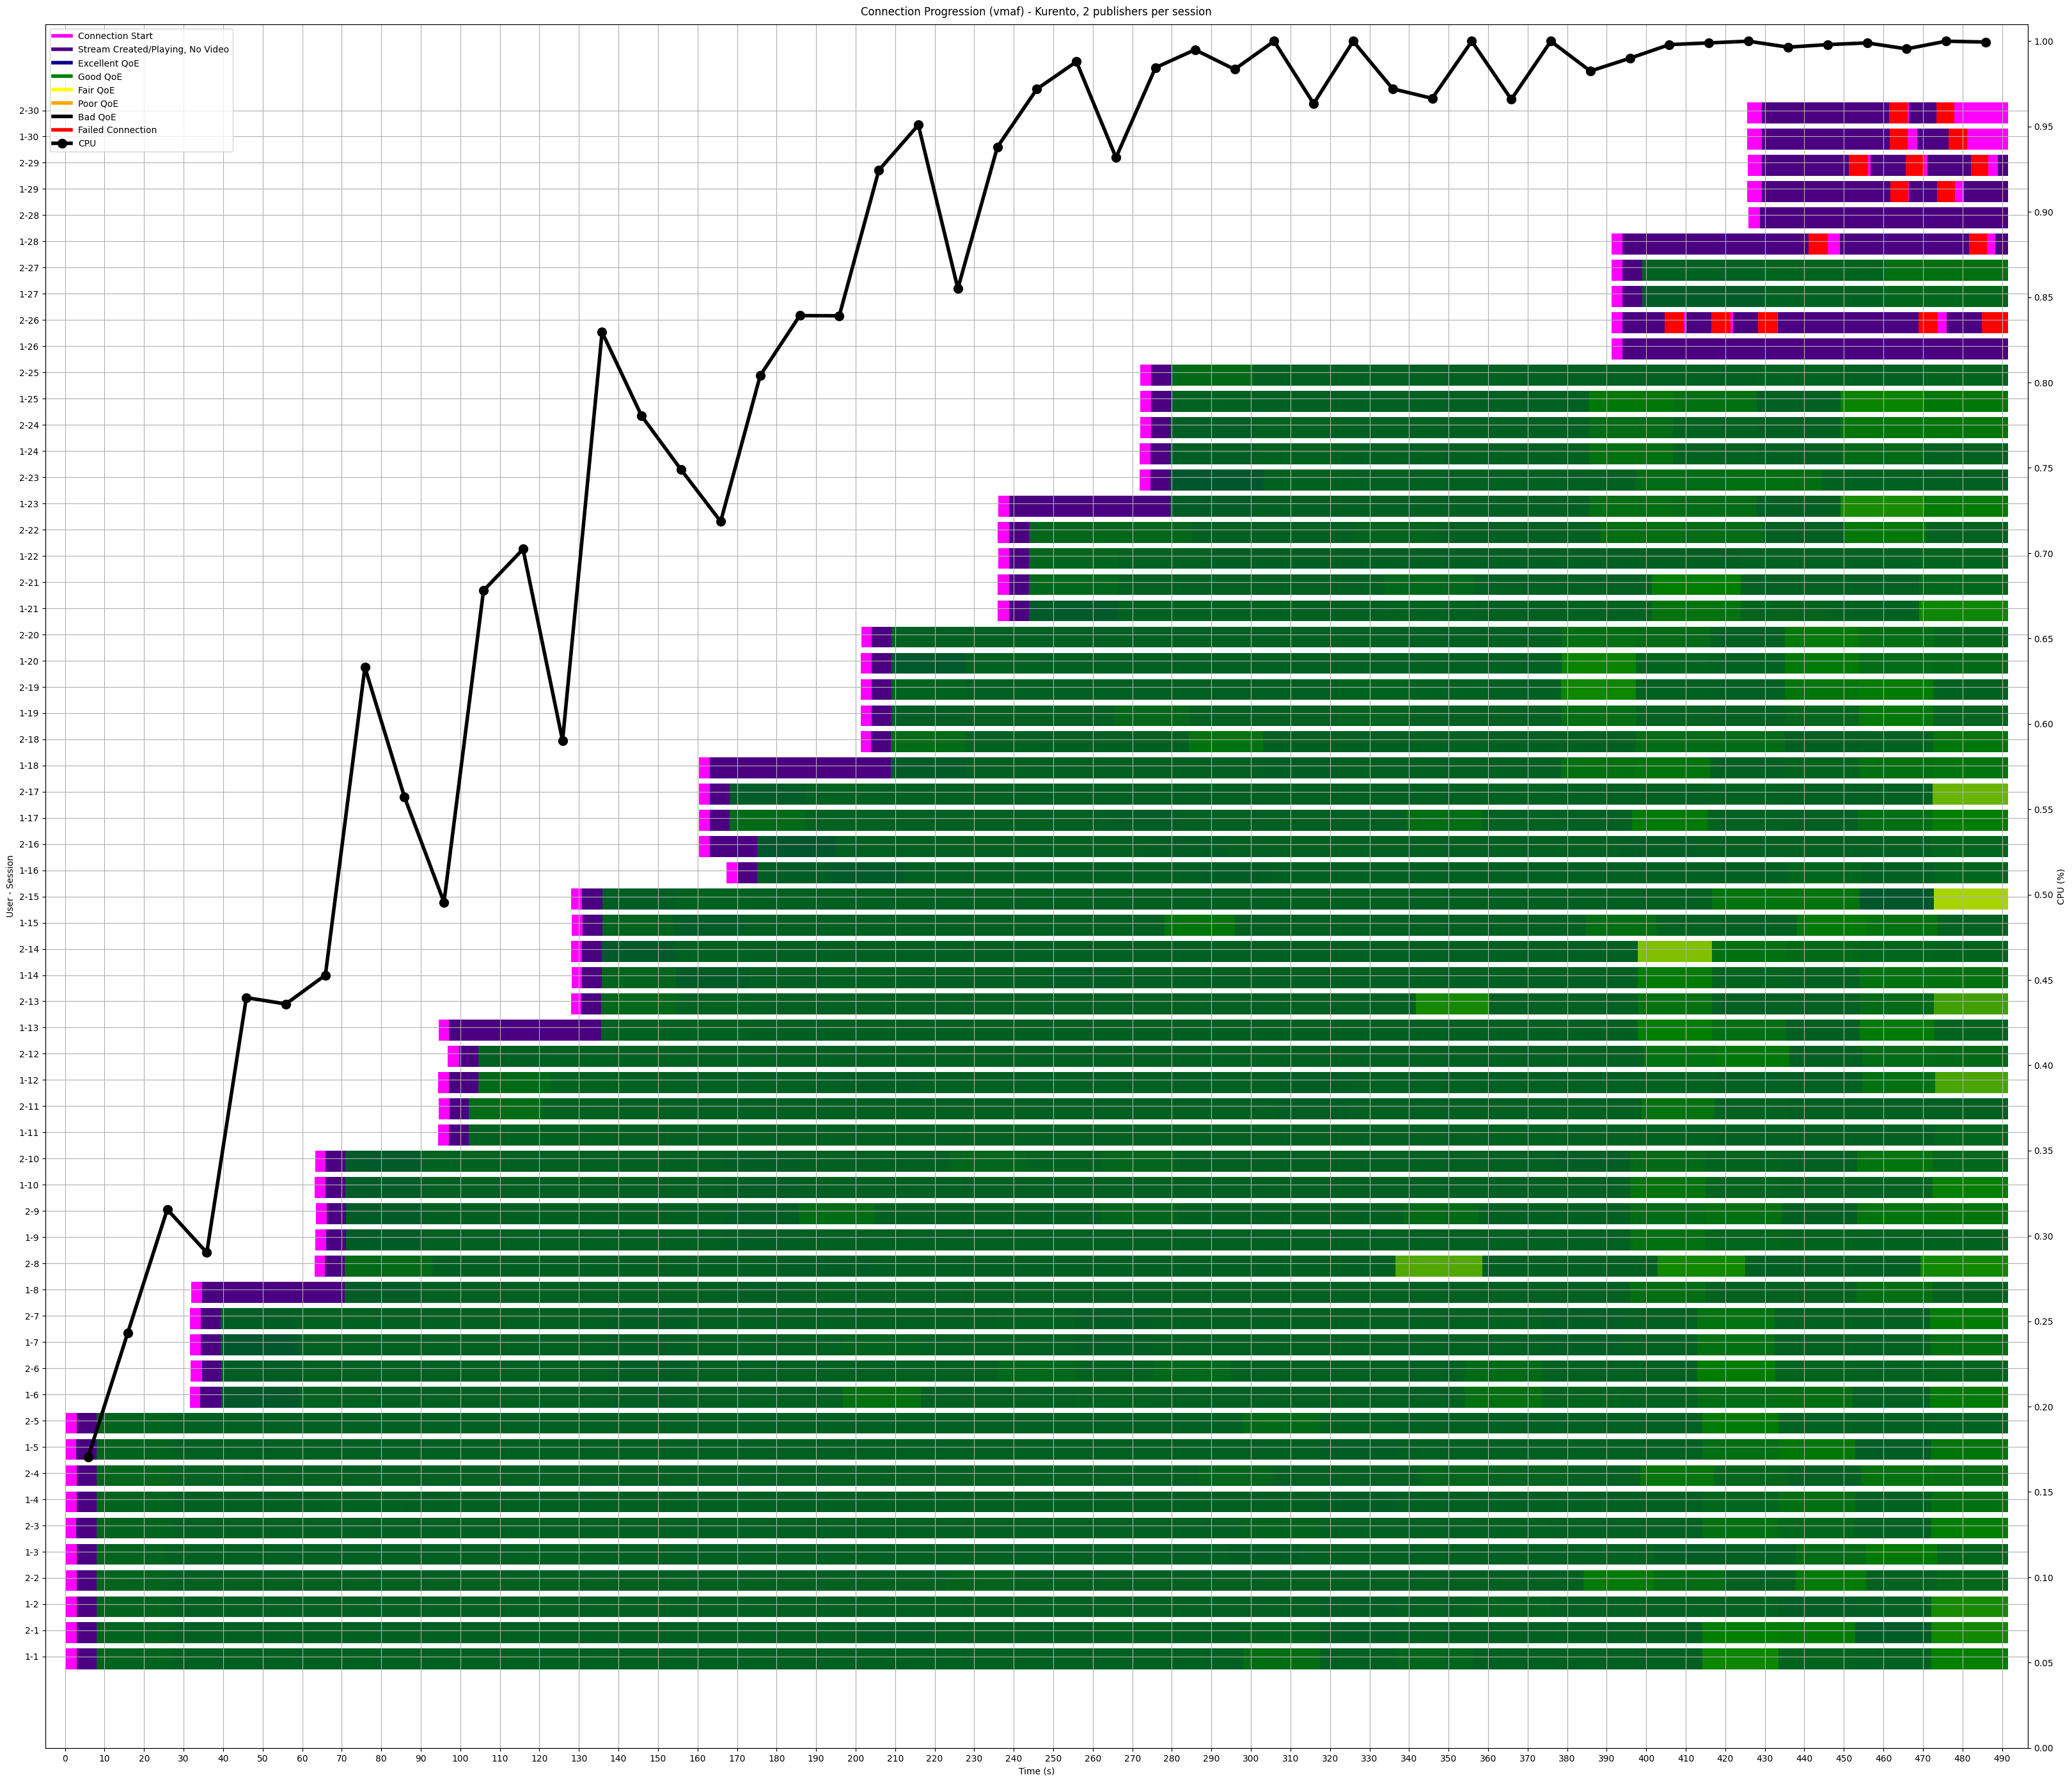

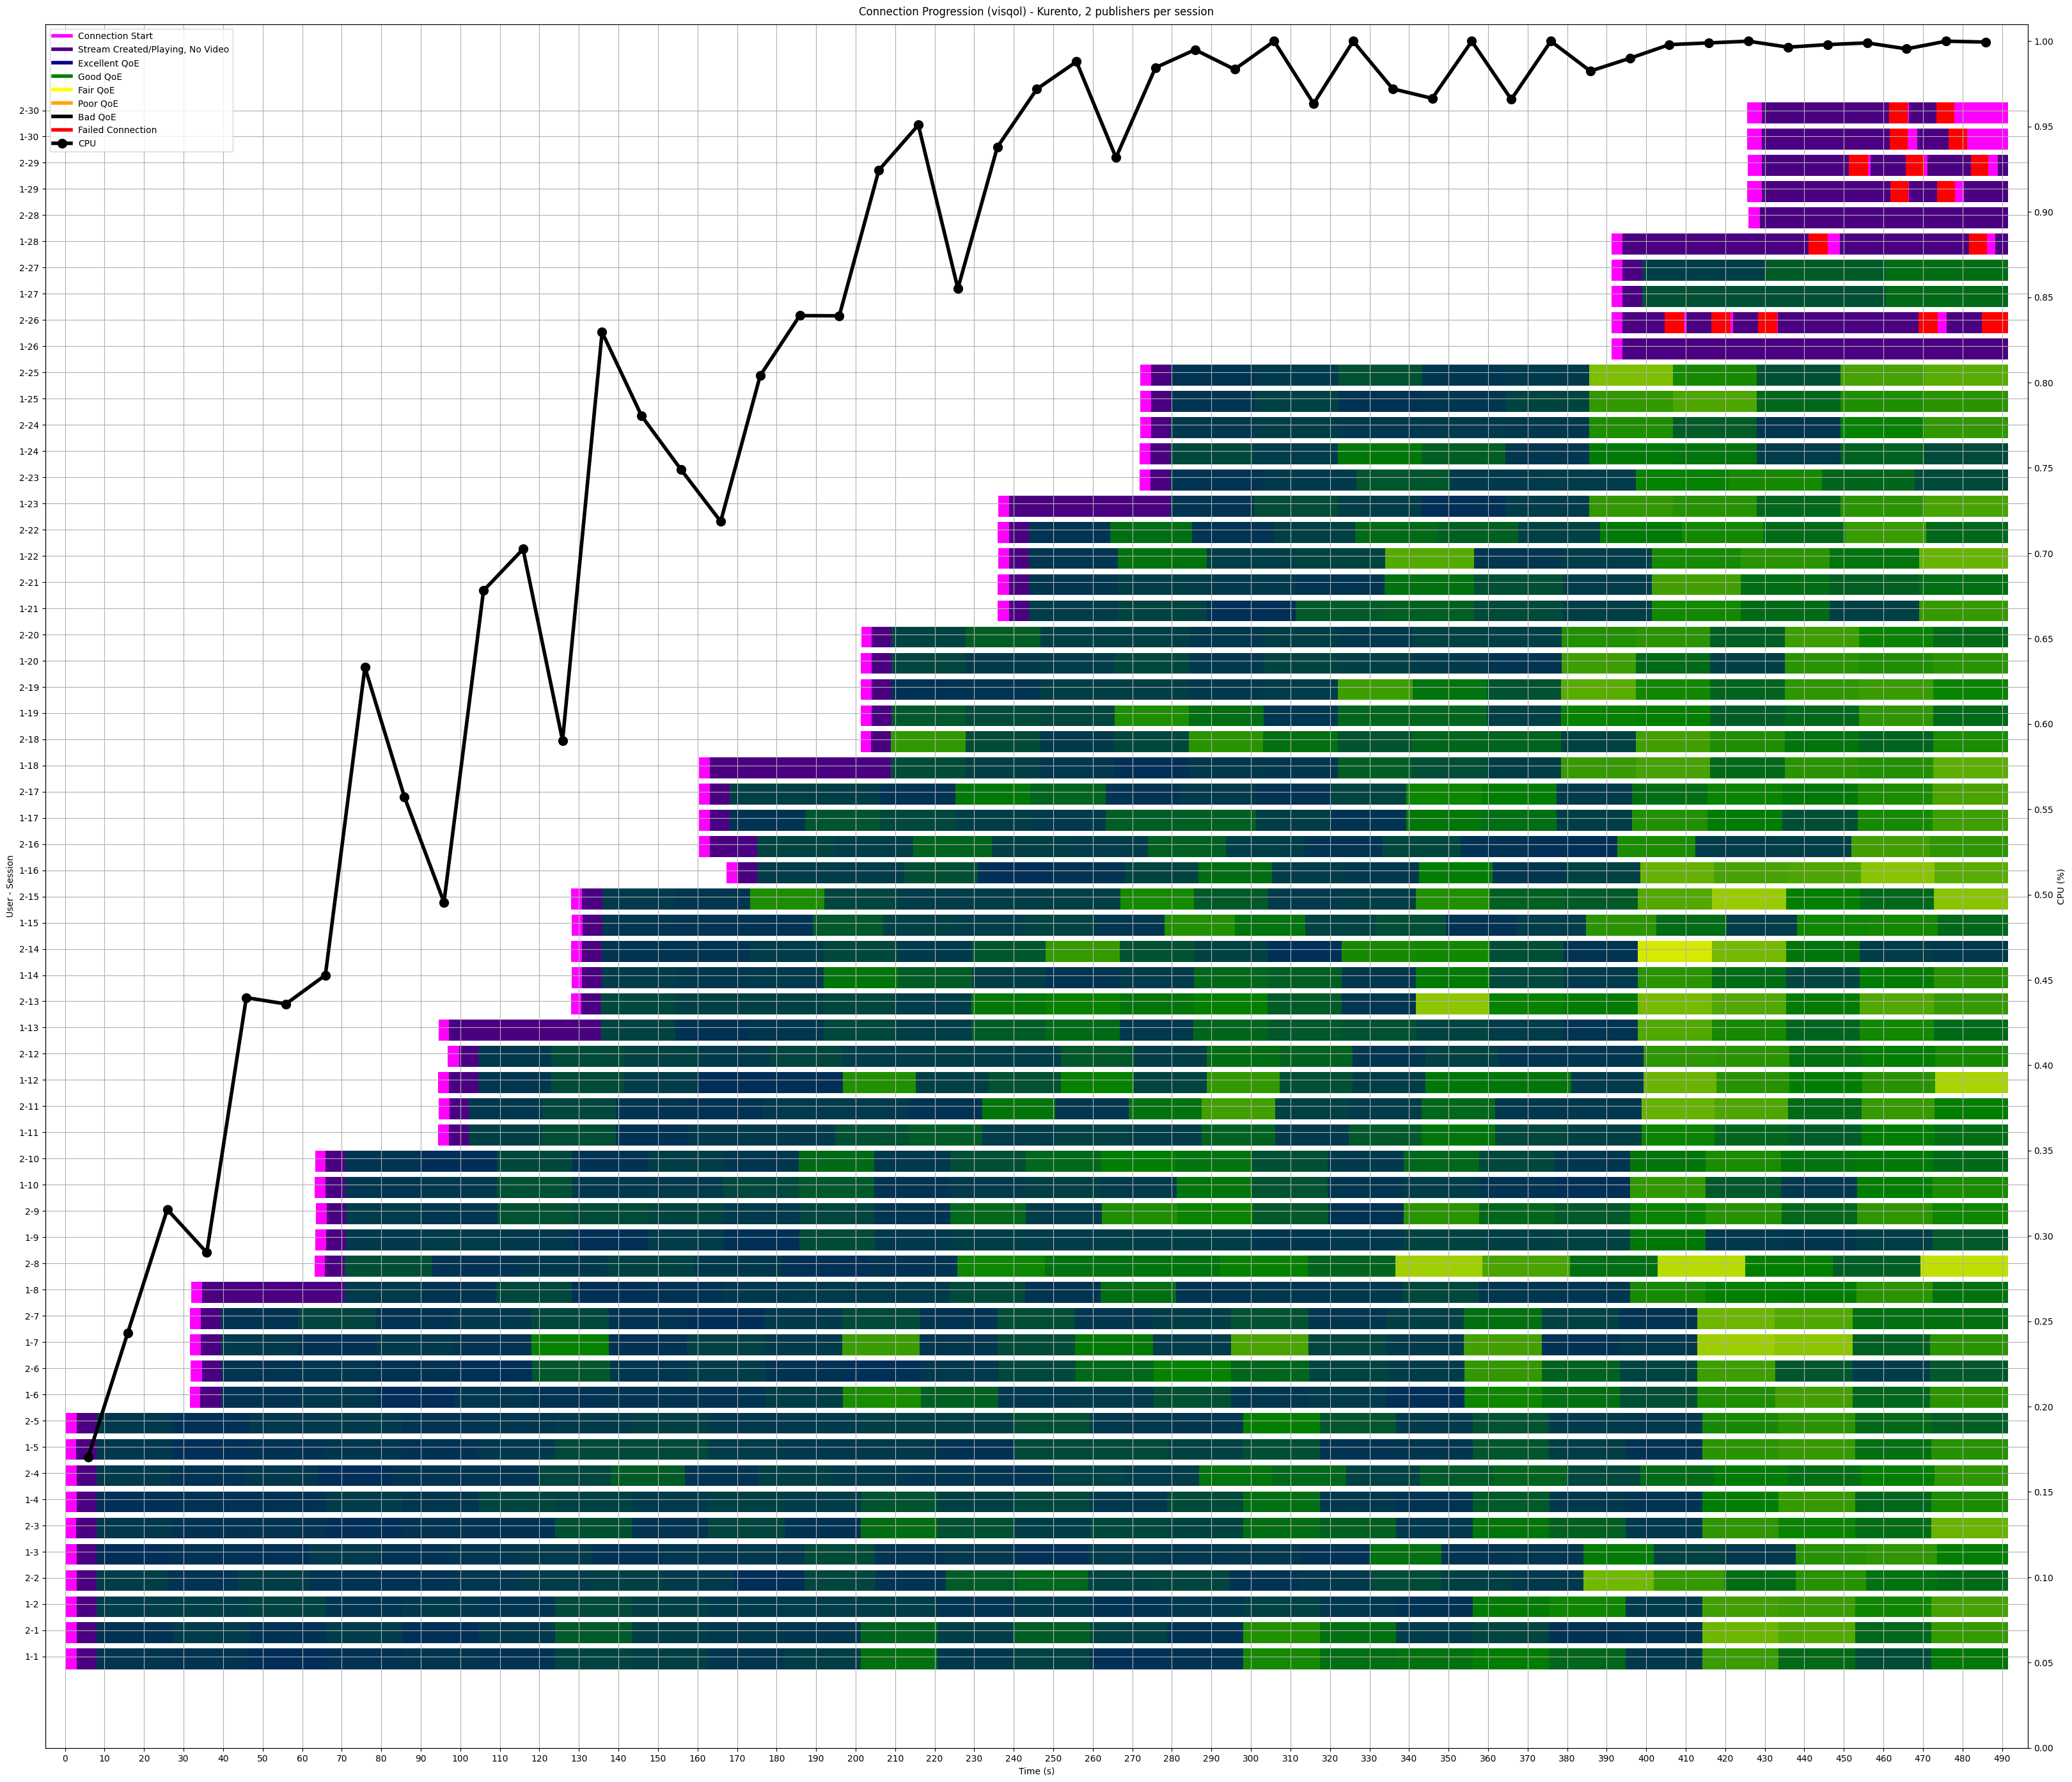

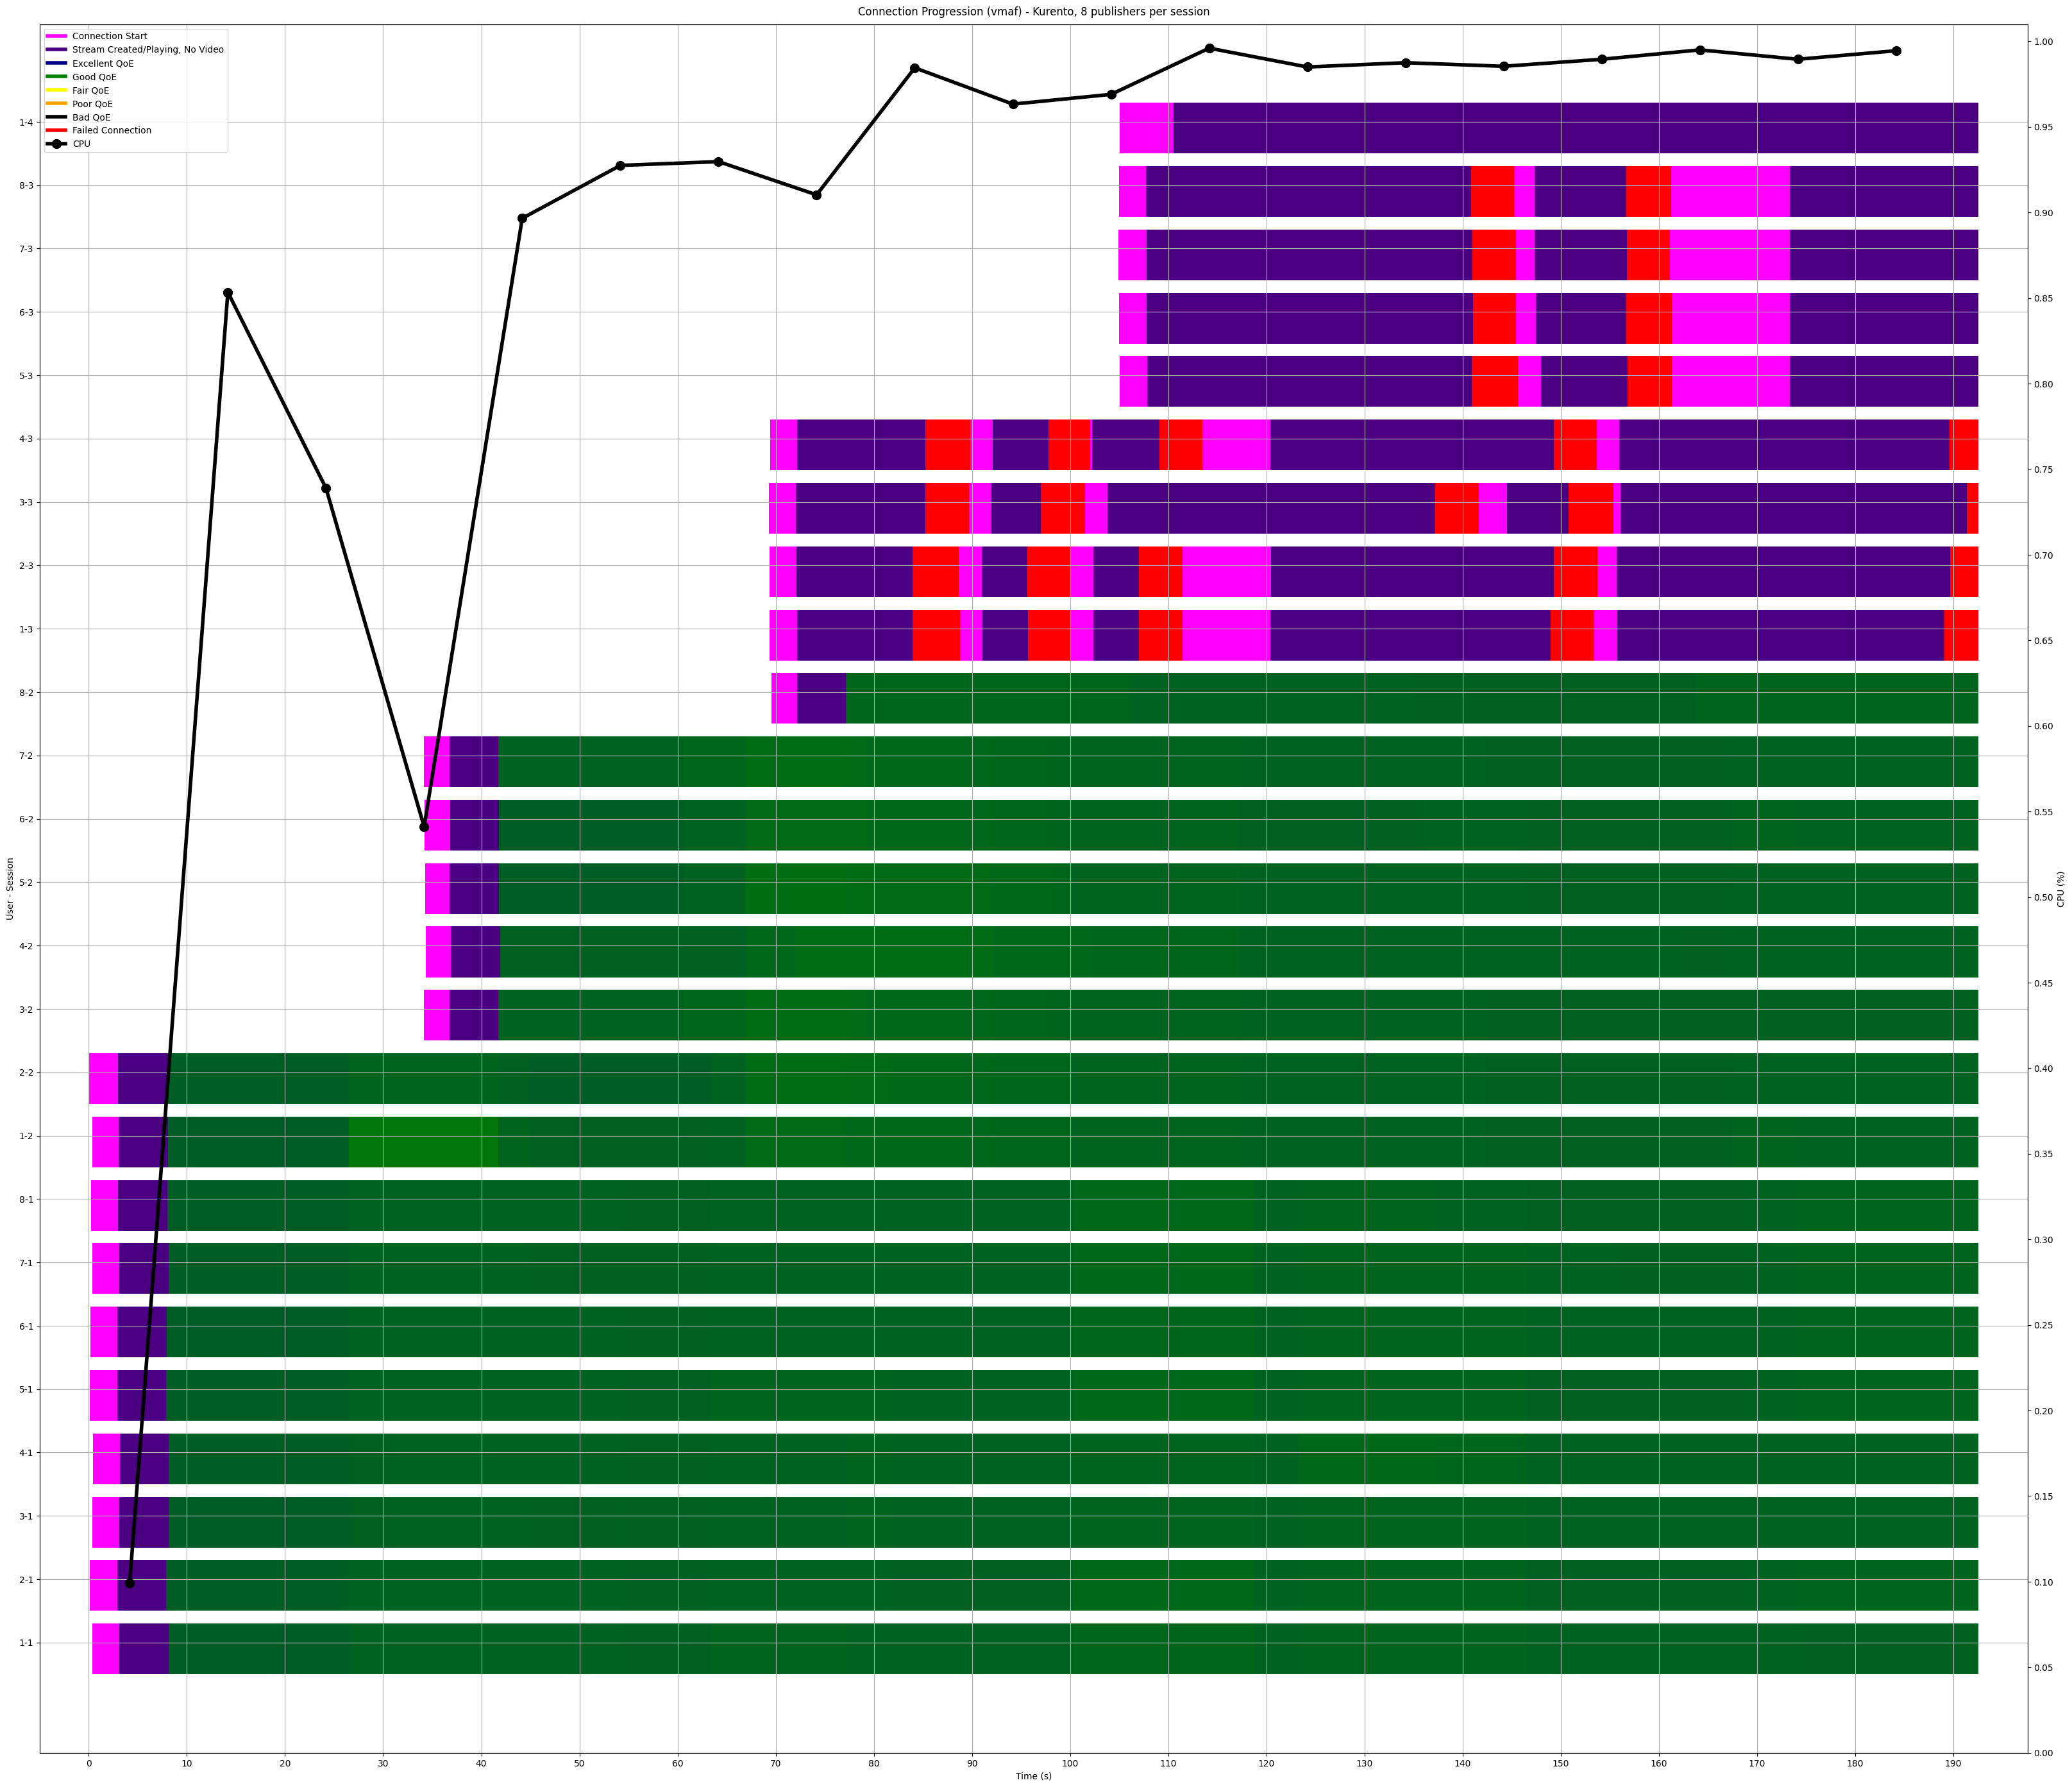

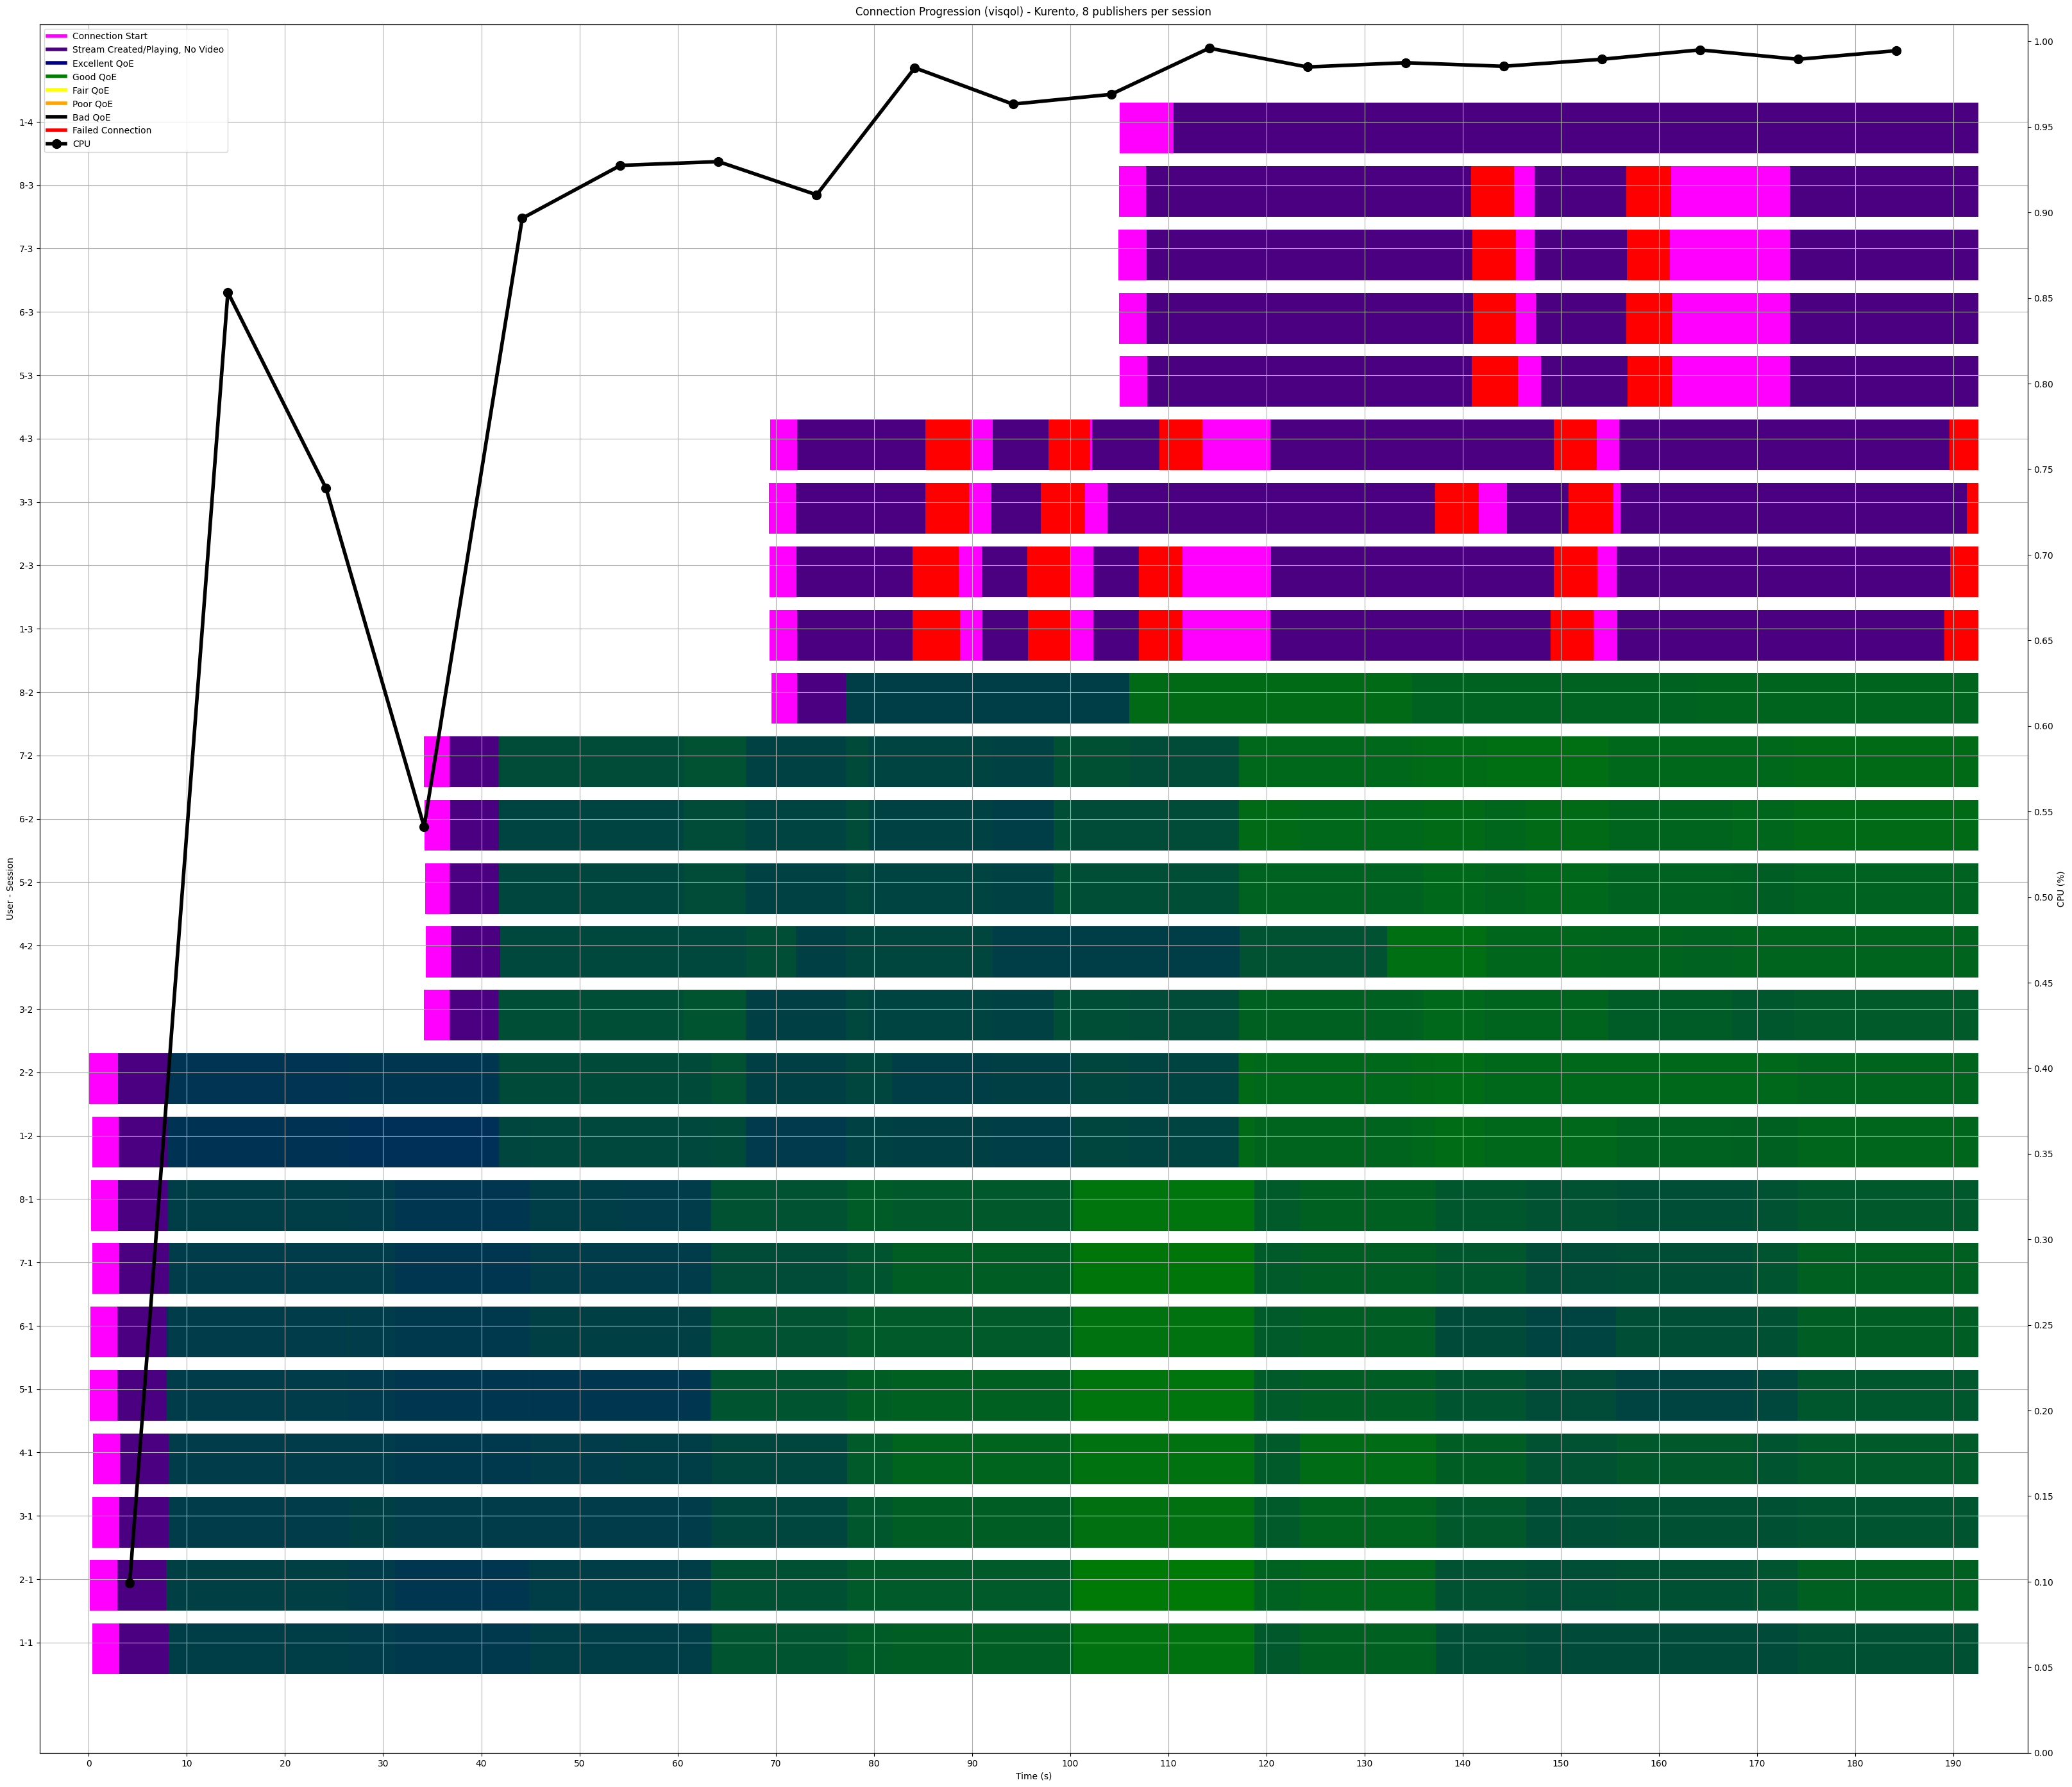

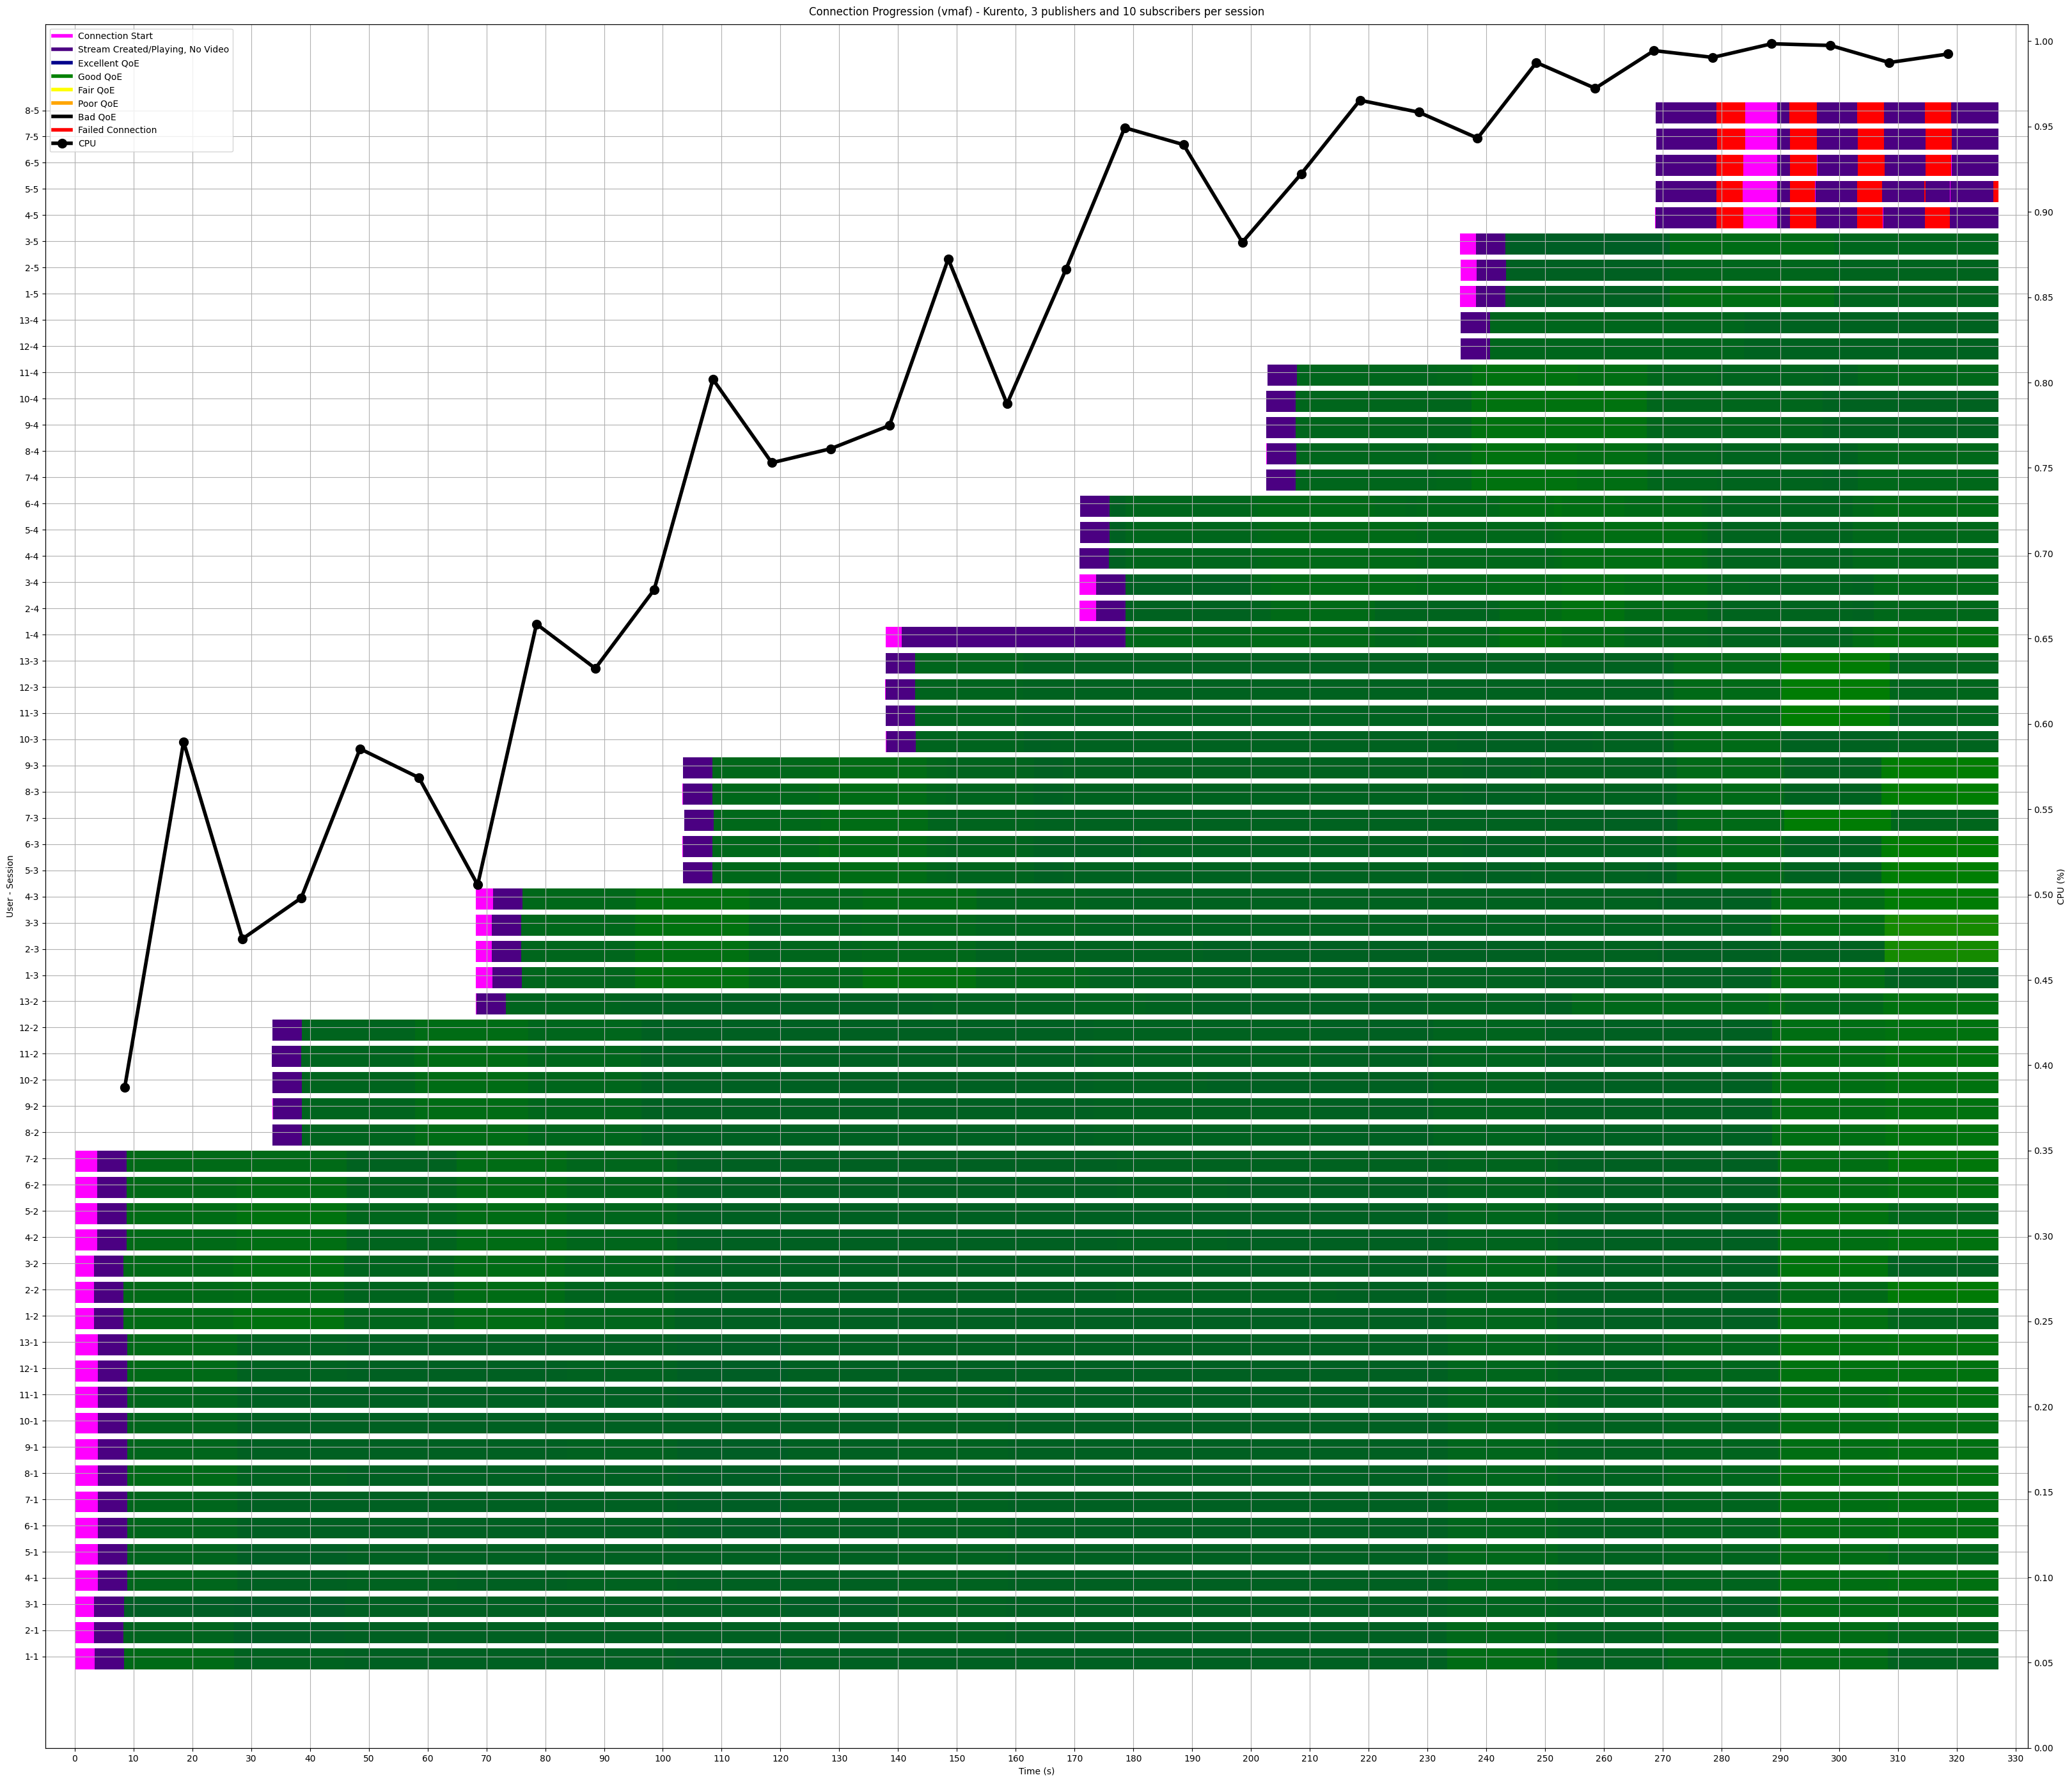

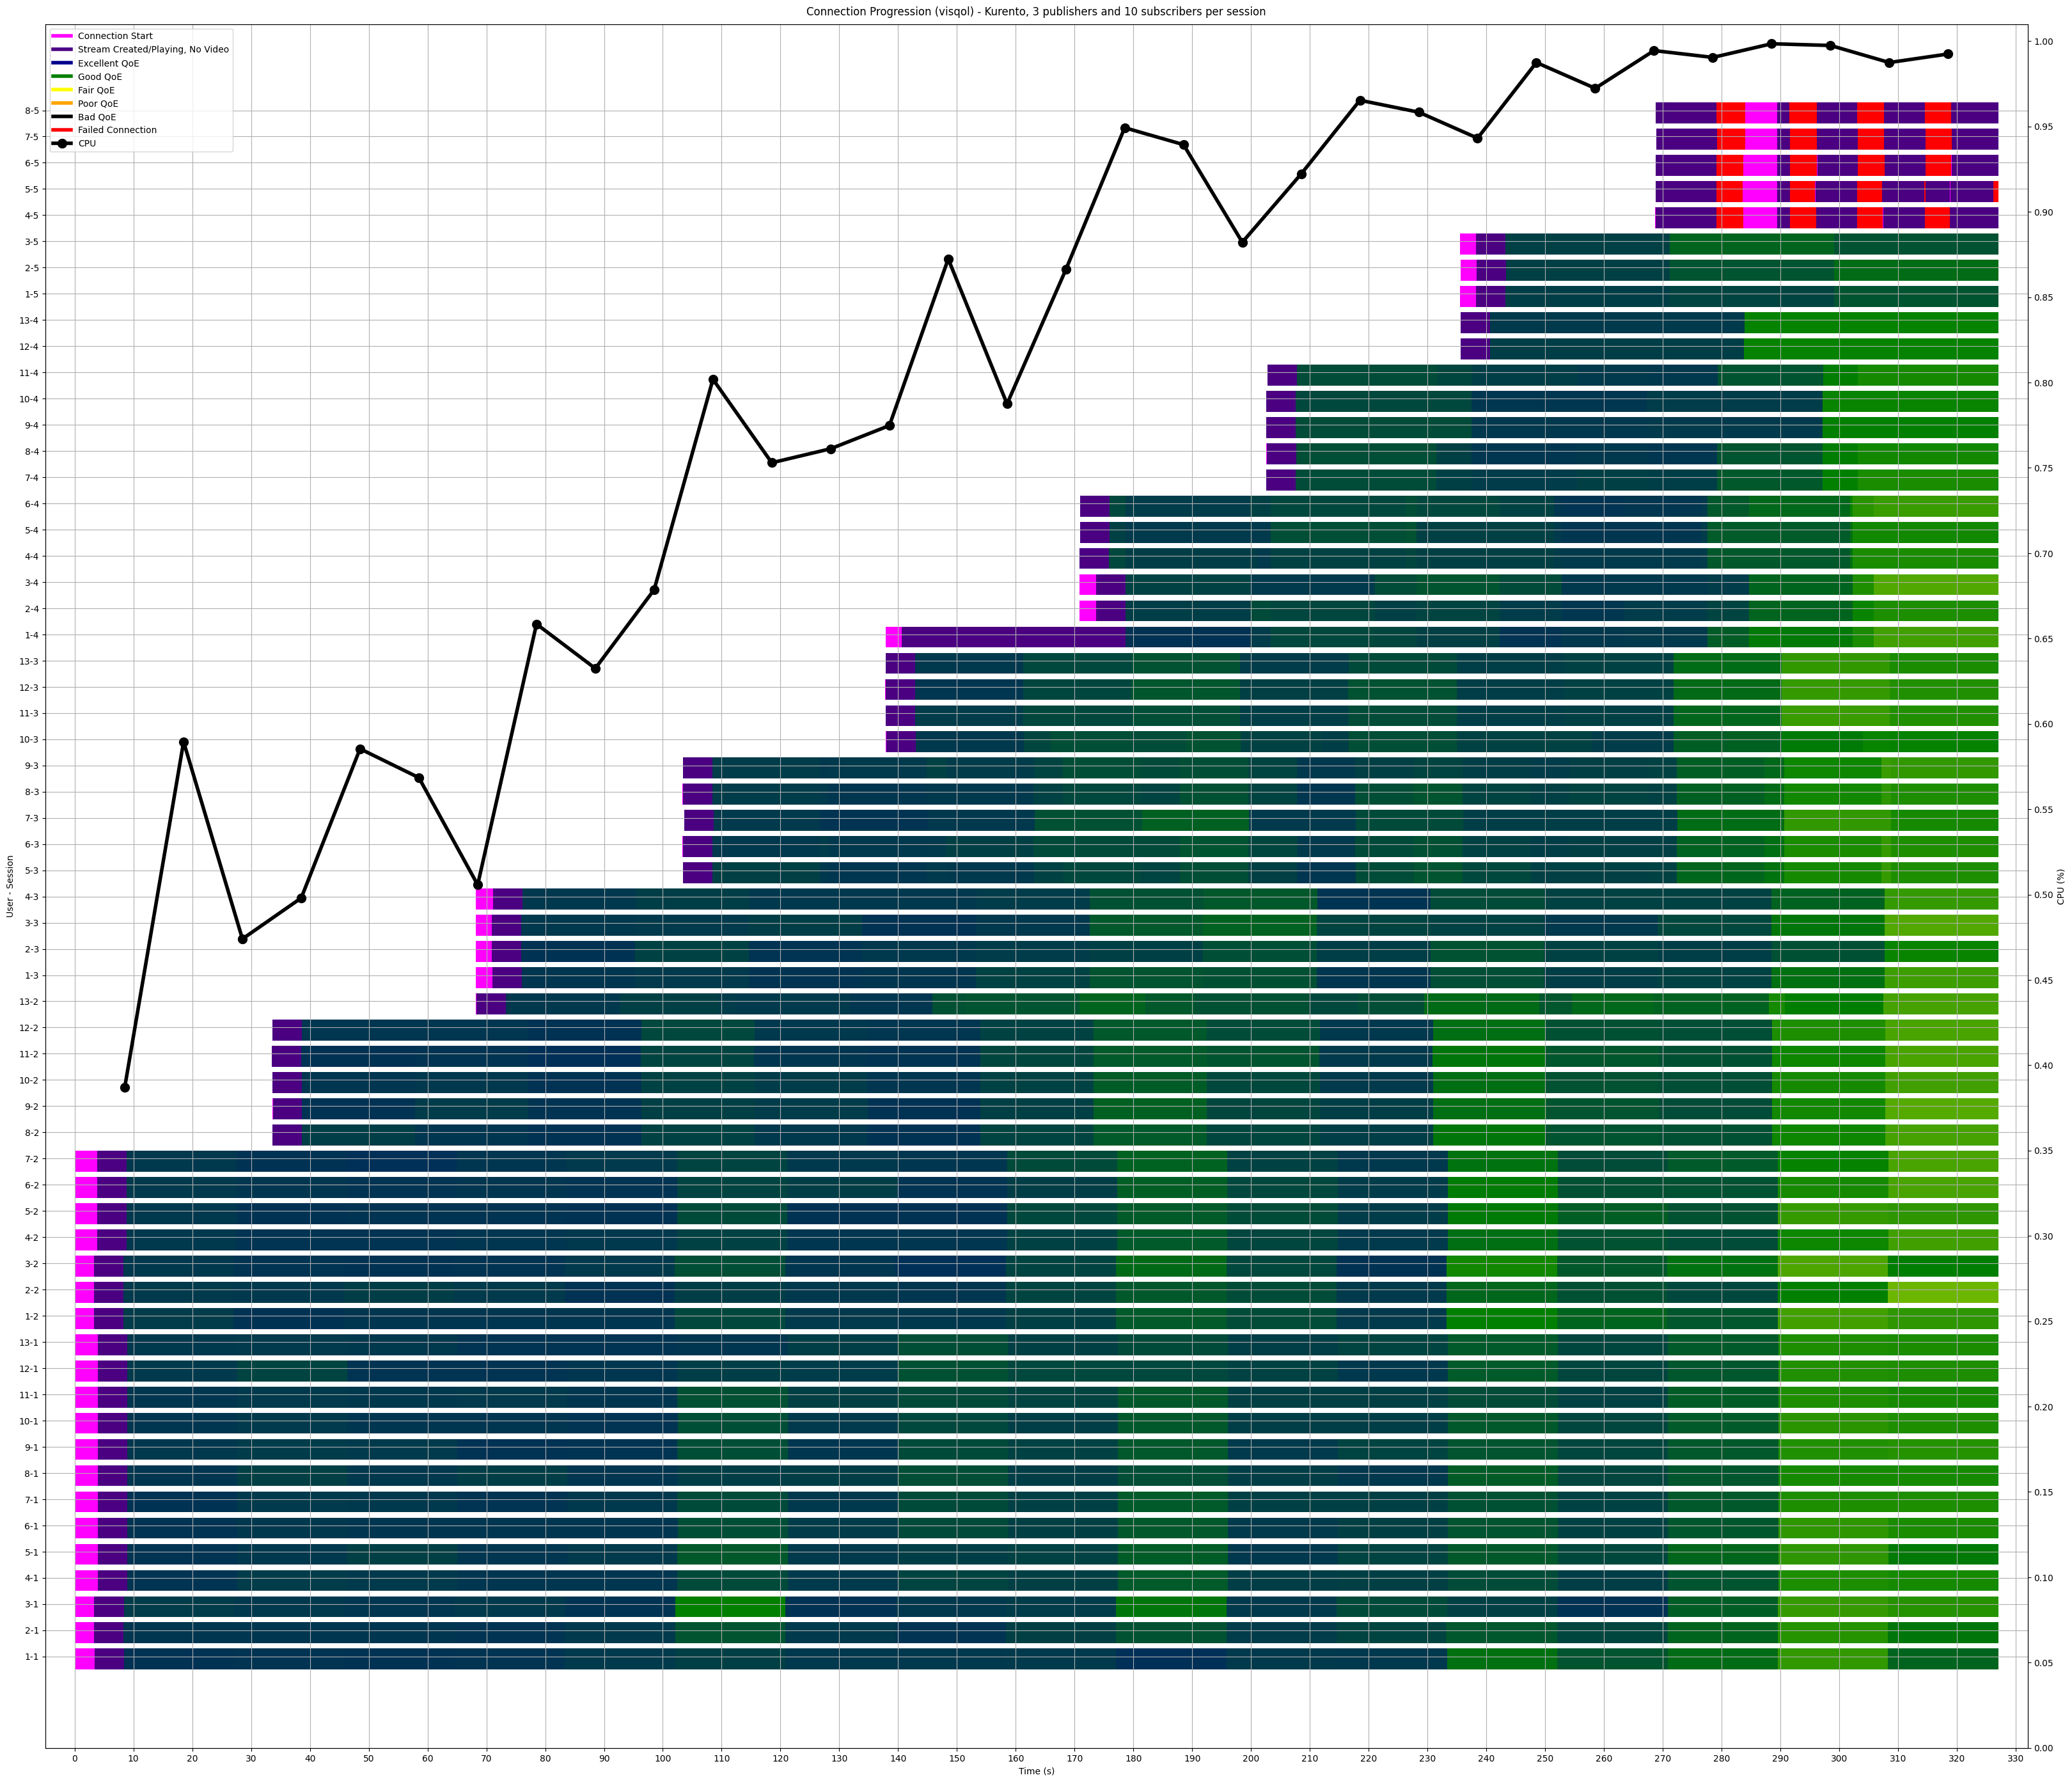

In [16]:
# Paint all tests
for i, index_list_name in enumerate(index_list_names):
    draw_cons_plot(i, index_list_name, "vmaf")
    draw_cons_plot(i, index_list_name, "visqol")

In [ ]:
# save connection relevant data to file for later reuse
os.makedirs("dfs_aux", exist_ok=True)
connection_stats_global.to_csv("dfs_aux/connection_stats.csv", index=False)

In [16]:
# alternative, read from file (avoids running long process)
connection_stats_global = pd.read_csv("dfs_aux/connection_stats.csv")

In [17]:
# Calculate how many publishers, subscribers, streams in and streams out there are at each time
def add_to(array, number, user, session, timestamp):
    array.append({
        "number": number,
        "user": user,
        "session": session,
        "timestamp": timestamp
    })
full_publishers_progression = {}
full_subscribers_progression = {}
full_streams_in_progression = {}
full_streams_out_progression = {}
def process_events_df(index_list_name, connection_stats):
    sessions = connection_stats['session'].unique()
    publishers_progression = []
    subscribers_progression = []
    streams_in_progression = []
    streams_out_progression = []

    previous_data = {'publishers': 0, 'subscribers': 0, 'streams_in': 0, 'streams_out': 0}
    for session in sessions:
        previous_data[session] = {'publishers': 0, 'subscribers': 0}

    for i, row in connection_stats.iterrows():
        session = row['session']
        user = row['user']
        type = row['type']
        full_user = row['full_user']
        timestamp = row['start_time']
        connected_users = set()

        if type == "connectionSuccess":
            if "0s" in index_list_name and int(user) > 3:
                subscribers = previous_data['subscribers'] + 1
                publishers_in_session = previous_data[session]['publishers']
                subscribers_in_session = previous_data[session]['subscribers'] + 1
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session

                previous_data['subscribers'] = subscribers
                previous_data[session]['subscribers'] = subscribers_in_session
            else:
                publishers = previous_data['publishers'] + 1
                streams_in = previous_data['streams_in'] + 2
                publishers_in_session = previous_data[session]['publishers'] + 1
                subscribers_in_session = previous_data[session]['subscribers']
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session

                previous_data['publishers'] = publishers
                previous_data['streams_in'] = streams_in
                previous_data[session]['publishers'] = publishers_in_session

            previous_data['streams_out'] = streams_out

            add_to(publishers_progression, previous_data['publishers'], user, session, timestamp)
            add_to(subscribers_progression, previous_data['subscribers'], user, session, timestamp)
            add_to(streams_in_progression, previous_data['streams_in'], user, session, timestamp)
            add_to(streams_out_progression, previous_data['streams_out'], user, session, timestamp)

            connected_users.add(full_user)

        elif type == "connectionFail" and full_user in connected_users:
            if "0s" in index_list_name and int(user) > 3:
                subscribers = previous_data['subscribers'] - 1
                publishers_in_session = previous_data[session]['publishers']
                subscribers_in_session = previous_data[session]['subscribers'] - 1
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session

                previous_data['subscribers'] = subscribers
                previous_data[session]['subscribers'] = subscribers_in_session
            else:
                publishers = previous_data['publishers'] - 1
                streams_in = previous_data['streams_in'] - 2
                publishers_in_session = previous_data[session]['publishers'] - 1
                subscribers_in_session = previous_data[session]['subscribers']
                streams_out = 2 * publishers_in_session * (publishers_in_session - 1) + 2 * subscribers_in_session * publishers_in_session

                previous_data['publishers'] = publishers
                previous_data['streams_in'] = streams_in
                previous_data[session]['publishers'] = publishers_in_session

            previous_data['streams_out'] = streams_out

            add_to(publishers_progression, previous_data['publishers'], user, session, timestamp)
            add_to(subscribers_progression, previous_data['subscribers'], user, session, timestamp)
            add_to(streams_in_progression, previous_data['streams_in'], user, session, timestamp)
            add_to(streams_out_progression, previous_data['streams_out'], user, session, timestamp)

            connected_users.remove(full_user)

    publishers_progression = pd.DataFrame(publishers_progression)
    subscribers_progression = pd.DataFrame(subscribers_progression)
    streams_in_progression = pd.DataFrame(streams_in_progression)
    streams_out_progression = pd.DataFrame(streams_out_progression)

    return (index_list_name, publishers_progression, subscribers_progression, streams_in_progression, streams_out_progression)

# Use parallel processing to handle events dataframes
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = [executor.submit(process_events_df, index_list_name, connection_stats_global[connection_stats_global["index"] == index_list_name]) for index_list_name in index_list_names]
    for future in as_completed(futures):
        (index_list_name, publishers_progression, subscribers_progression, streams_in_progression, streams_out_progression) = future.result()
        full_publishers_progression[index_list_name] = publishers_progression
        full_subscribers_progression[index_list_name] = subscribers_progression
        full_streams_in_progression[index_list_name] = streams_in_progression
        full_streams_out_progression[index_list_name] = streams_out_progression

In [18]:
# calculate certain values when in a CPU threshold interval
def calculate_connection_data(connection_type, connection_stats, metric_to_check, label, qoe_metric=None):
    connection_stats = connection_stats[connection_stats["type"] == connection_type].drop(columns=["type", "index", "user", "session"])
    connection_stats = connection_stats.sort_values(by="cpu_median").reset_index().drop(columns=["index"])

    cols_to_keep = ["full_user", "attempt", "batch", "total_duration", "cpu_median", "cpu_mean", "cpu_max", "cpu_min"]
    if connection_type == "QOE":
        cols_to_keep += ["qoe", "qoe_metric"]
    connection_stats = connection_stats[cols_to_keep]
    
    if connection_type == "QOE":
        connection_stats = connection_stats[connection_stats["qoe_metric"] == qoe_metric]

    thresholds = [
        { "threshold": "Full test", "condition": connection_stats["total_duration"] == connection_stats["total_duration"] },
        {"threshold": "Median CPU < 0.8", "condition": connection_stats["cpu_median"] < 0.8},
        {"threshold": "0.8 <= Median CPU < 0.9", "condition": (connection_stats["cpu_median"] >= 0.8) & (connection_stats["cpu_median"] < 0.9)},
        {"threshold": "0.9 <= Median CPU <= 1", "condition": (connection_stats["cpu_median"] >= 0.9)},
        {"threshold": "0.9 < Median CPU <= 0.95", "condition": (connection_stats["cpu_median"] >= 0.9) & (connection_stats["cpu_median"] < 0.95)},
        {"threshold": "0.95 < Median CPU", "condition": connection_stats["cpu_median"] >= 0.95},
    ]
    
    cpu_start_durations = []
    filtered_connection_stats = []
    
    for threshold in thresholds:
        filtered_stats = connection_stats[threshold["condition"]]
        mean = filtered_stats[metric_to_check].mean()
        median = filtered_stats[metric_to_check].median()
        min_val = filtered_stats[metric_to_check].min()
        max_val = filtered_stats[metric_to_check].max()
        std = filtered_stats[metric_to_check].std()
        
        cpu_start_durations.append({
            "threshold": threshold["threshold"],
            f"median {label}": median,
            f"mean {label}": mean,
            f"min {label}": min_val,
            f"max {label}": max_val,
            f"std {label}": std,
        })
        
        filtered_connection_stats.append(filtered_stats)
    
    cpu_start_durations_df = pd.DataFrame(cpu_start_durations)

    return (
        cpu_start_durations_df,
        *filtered_connection_stats,
    )

In [41]:
# Helper functions for comparing the certain values averages between different CPU thresholds using Mann-Whitney U test and t-test
from scipy import stats

def find_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers

def get_cases(connection_stats, con_type="QOE", label="VMAF", qoe_metric="vmaf"):
    if con_type == "QOE":
        metric_to_check = "qoe"
    else:
        metric_to_check = "total_duration"
    cpu_start_durations_df, con_0_100, con_0_80, con_80_90, con_90_100, con_90_95, con_95_100 = calculate_connection_data(
        con_type, connection_stats, metric_to_check, label, qoe_metric
    )
    display(cpu_start_durations_df)
    con_0_90 = pd.concat([con_0_80, con_80_90])
    con_0_95 = pd.concat([con_0_80, con_80_90, con_90_95])
    cases = [
        # {
        #     "X": "CPU < 0.8",
        #     "Y": "CPU >= 0.8 and < 0.9",
        #     "len(X)": len(con_0_80),
        #     "len(Y)": len(con_80_90),
        #     "XSeries": con_0_80[metric_to_check],
        #     "YSeries": con_80_90[metric_to_check],
        # },
        # {
        #     "X": "CPU >= 0.8 and < 0.9",
        #     "Y": "CPU >= 0.9",
        #     "len(X)": len(con_80_90),
        #     "len(Y)": len(con_90_100),
        #     "XSeries": con_80_90[metric_to_check],
        #     "YSeries": con_90_100[metric_to_check],
        # },
        {
            "X": "CPU < 0.9",
            "Y": "CPU >= 0.9",
            "len(X)": len(con_0_90),
            "len(Y)": len(con_90_100),
            "XSeries": con_0_90[metric_to_check],
            "YSeries": con_90_100[metric_to_check],
            "XSeriesCPU": con_0_90["cpu_median"],
            "YSeriesCPU": con_90_100["cpu_median"],
        },
        {
            "X": "CPU < 0.95",
            "Y": "CPU >= 0.95",
            "len(X)": len(con_0_95),
            "len(Y)": len(con_95_100),
            "XSeries": con_0_95[metric_to_check],
            "YSeries": con_95_100[metric_to_check],
            "XSeriesCPU": con_0_95["cpu_median"],
            "YSeriesCPU": con_95_100["cpu_median"],
        },
    ]
    return cases

def clean_outliers(serie, outliers):
    serie = serie[~serie.isin(outliers)]
    return serie

def calculate_comparisons(X, Y, XSeries, YSeries, lenX, lenY):
    ustat, p = stats.mannwhitneyu(XSeries, YSeries)
    tstat, tp = stats.ttest_ind(XSeries, YSeries)
    # wstat, wp, zw = stats.wilcoxon(XSeries, YSeries)
    shapiroX = stats.shapiro(XSeries)
    shapiroY = stats.shapiro(YSeries)
    levene = stats.levene(XSeries, YSeries, center="mean")
    brown_forsythe = stats.levene(XSeries, YSeries, center="median")
    meanX = XSeries.mean()
    meanY = YSeries.mean()
    medianX = XSeries.median()
    medianY = YSeries.median()
    stdX = XSeries.std()
    stdY = YSeries.std()
    pooled_std = np.sqrt(((lenX - 1) * stdX ** 2 + (lenY - 1) * stdY ** 2) / (lenX + lenY - 2))
    cohen_d = (meanX - meanY) / pooled_std
    rankBiserialCorrelation = (2 * ustat) / (lenX * lenY) - 1
    basics = {
        "X": X,
        "Y": Y,
        "len(X)": lenX,
        "len(Y)": lenY,
        "mean(X)": meanX,
        "mean(Y)": meanY,
        "median(X)": medianX,
        "median(Y)": medianY,
        "std(X)": stdX,
        "std(Y)": stdY,
    }
    comparisons = {
        "X": X,
        "Y": Y,
        "len(X)": lenX,
        "len(Y)": lenY,
        # "Wilcoxon (W)": wstat,
        # "p-value (Wilcoxon)": wp,
        # "z-statistic (Wilcoxon)": zw,
        "U (MWU)": ustat,
        "p-value (MWU)": p,
        "effect size (MWU, rank-biserial correlation)": rankBiserialCorrelation,
        "t (t-test)": tstat,
        "p-value (t-test)": tp,
        "effect size (t-test, Cohen's d)": cohen_d,
        "Shapiro X": shapiroX,
        "Shapiro Y": shapiroY,
        "Levene": levene,
        "Brown-Forsythe": brown_forsythe,
    }
    return basics, comparisons

def make_comparisons(cases, index=None):
    comparisons = []
    comparisons_clean = []
    basics = []
    basics_clean = []
    fig, axs = plt.subplots(1, len(cases), figsize=(15, 5))
    for i, case in enumerate(cases):
        X = case["X"]
        Y = case["Y"]
        lenX = case["len(X)"]
        lenY = case["len(Y)"]
        XSeries = case["XSeries"]
        YSeries = case["YSeries"]
        outliersX = find_outliers_iqr(XSeries)
        outliersY = find_outliers_iqr(YSeries)
        # clean outliers
        clean_XSeries = clean_outliers(XSeries, outliersX)
        clean_YSeries = clean_outliers(YSeries, outliersY)
        XSeriesCPU = case["XSeriesCPU"]
        YSeriesCPU = case["YSeriesCPU"]
        # plot boxplots
        fig.set_tight_layout(True)
        fig.suptitle(f"{index if index else "All cases"}")
        axs[i].boxplot([XSeries, YSeries], labels=[X + f"\n(n = {str(lenX)})", Y + f"\n(n = {str(lenY)})"])
        axs[i].set_title(f"{X} vs {Y}")
        axs[i].set_ylabel("QoE")
        axs[i].set_ylim(0, 1)
        # set y ticks
        y_ticks = np.arange(0, 1.01, 0.05)
        axs[i].set_yticks(y_ticks)
        axs[i].grid(True)
        fig.savefig(f"plots/boxplots/{index if index else 'all'}.png")
        basic, comparison = calculate_comparisons(X, Y, XSeries, YSeries, lenX, lenY)
        basic["X"] = X
        basic["Y"] = Y
        basic["len(outliers(X))"] = len(outliersX)
        basic["len(outliers(Y))"] = len(outliersY)
        comparison["X"] = X
        comparison["Y"] = Y
        comparisons.append(comparison)
        basics.append(basic)
        basic_clean, comparison_clean = calculate_comparisons(X, Y, clean_XSeries, clean_YSeries, lenX - len(outliersX), lenY - len(outliersY))
        basic_clean["X"] = X
        basic_clean["Y"] = Y
        basic_clean["len(outliers(X))"] = len(outliersX)
        basic_clean["len(outliers(Y))"] = len(outliersY)
        comparison_clean["X"] = X
        comparison_clean["Y"] = Y
        comparisons_clean.append(comparison_clean)
        basics_clean.append(basic_clean)
    basics_df = pd.DataFrame(basics)
    comparisons_df = pd.DataFrame(comparisons)
    basics_clean_df = pd.DataFrame(basics_clean)
    comparisons_clean_df = pd.DataFrame(comparisons_clean)
    return basics_df, comparisons_df, basics_clean_df, comparisons_clean_df


'loadtest-webrtc-2024-kurento-2p'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.809220,0.803009,0.583712,0.831782,0.019303
1,Median CPU < 0.8,0.809252,0.809080,0.787569,0.829862,0.004531
2,0.8 <= Median CPU < 0.9,0.809420,0.809458,0.787233,0.829320,0.004859
3,0.9 <= Median CPU <= 1,0.809180,0.800757,0.583712,0.831782,0.021938
4,0.9 < Median CPU <= 0.95,0.809488,0.809286,0.781048,0.825381,0.006856
5,0.95 < Median CPU,0.809139,0.800233,0.583712,0.831782,0.022435


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,251,691,0.809209,0.800757,0.809292,0.809180,0.004640,0.021938,63,135
1,CPU < 0.95,CPU >= 0.95,291,651,0.809220,0.800233,0.809326,0.809139,0.004988,0.022435,78,125


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,188,556,0.809310,0.808647,0.809297,0.809305,0.000376,0.003185,63,135
1,CPU < 0.95,CPU >= 0.95,213,526,0.809323,0.808430,0.809313,0.809276,0.000385,0.003565,78,125


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,251,691,103164.0,8.432645e-06,0.189615,6.053262,2.048726e-09,0.446107,"(0.6773506999015808, 1.2993522092786842e-21)","(0.5282973051071167, 2.5100016054032194e-39)","(101.91523767225954, 8.03104876635692e-23)","(30.376571931341058, 4.595767227091528e-08)"
1,CPU < 0.95,CPU >= 0.95,291,651,118013.0,1.572304e-09,0.245908,6.757433,2.460700e-11,0.476508,"(0.672258734703064, 2.325113086736472e-23)","(0.5335550308227539, 3.08847975199224e-38)","(120.45098016466079, 1.8775197572631243e-26)","(35.59771490186074, 3.432342341343607e-09)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,188,556,53000.0,0.772795,0.014082,2.846625,0.004541,0.240160,"(0.9895750284194946, 0.18683741986751556)","(0.7335771322250366, 7.060590981954176e-29)","(75.29362927930484, 2.549156454659799e-17)","(44.810545791521996, 4.282242534787759e-11)"
1,CPU < 0.95,CPU >= 0.95,213,526,59501.0,0.185330,0.062157,3.649457,0.000281,0.296393,"(0.980524480342865, 0.004818159155547619)","(0.7153432369232178, 6.207382349878756e-29)","(93.76749207365027, 5.899913432378979e-21)","(49.88896718352123, 3.77040199468138e-12)"


'loadtest-webrtc-2024-kurento-8p'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.806343,0.805460,0.766138,0.823607,0.006209
1,Median CPU < 0.8,0.812775,0.812503,0.766138,0.823607,0.007209
2,0.8 <= Median CPU < 0.9,0.808228,0.808890,0.796842,0.819198,0.004293
3,0.9 <= Median CPU <= 1,0.805627,0.804025,0.785036,0.814534,0.005162
4,0.9 < Median CPU <= 0.95,0.805947,0.802709,0.785036,0.814534,0.007498
5,0.95 < Median CPU,0.805593,0.804375,0.788334,0.811920,0.004280


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,109,452,0.811410,0.804025,0.810335,0.805627,0.006658,0.005162,1,16
1,CPU < 0.95,CPU >= 0.95,204,357,0.807358,0.804375,0.808194,0.805593,0.008279,0.004280,28,7


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,108,436,0.811829,0.804562,0.810470,0.805786,0.005041,0.004394,1,16
1,CPU < 0.95,CPU >= 0.95,176,350,0.809834,0.804620,0.808512,0.805676,0.004888,0.003944,28,7


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,109,452,42447.0,9.333976e-32,0.723106,12.622767,2.574536e-32,1.346956,"(0.7776136994361877, 1.4938023040755866e-11)","(0.8994035720825195, 1.1101135059120545e-16)","(3.2415388921689035, 0.07233212251467389)","(3.6149034207983783, 0.0577779904923446)"
1,CPU < 0.95,CPU >= 0.95,204,357,50841.0,5.651283e-15,0.396194,5.620355,3.010414e-08,0.493283,"(0.8981667757034302, 1.4309085860642057e-10)","(0.9327247738838196, 1.296490345636947e-11)","(37.67411180491708, 1.585360055047743e-09)","(32.42166550322862, 2.0065125141468212e-08)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,108,436,40719.0,7.568534e-32,0.729485,14.927622,1.852375e-42,1.604482,"(0.9500792026519775, 0.0004860473272856325)","(0.9213569164276123, 2.526148879650452e-14)","(9.502531024371212, 0.0021562668758516577)","(7.66388786045328, 0.005826478443936789)"
1,CPU < 0.95,CPU >= 0.95,176,350,49161.0,6.189411e-29,0.596136,13.175699,1.912916e-34,1.217520,"(0.9466927647590637, 3.6234773688192945e-06)","(0.940365195274353, 1.1869483174109519e-10)","(7.543857680168363, 0.006228646022289483)","(3.2571932819507796, 0.07168470781746596)"


'loadtest-webrtc-2024-kurento-3p-10s'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.806738,0.800679,0.727141,0.817298,0.012197
1,Median CPU < 0.8,0.808281,0.801946,0.774452,0.817298,0.010033
2,0.8 <= Median CPU < 0.9,0.809058,0.805134,0.776934,0.811238,0.006671
3,0.9 <= Median CPU <= 1,0.806290,0.799327,0.727141,0.814411,0.013508
4,0.9 < Median CPU <= 0.95,0.808287,0.806892,0.786964,0.814411,0.004662
5,0.95 < Median CPU,0.801392,0.796779,0.727141,0.812564,0.014525


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,316,520,0.802905,0.799327,0.808707,0.806290,0.009259,0.013508,7,17
1,CPU < 0.95,CPU >= 0.95,447,389,0.804073,0.796779,0.808359,0.801392,0.008378,0.014525,19,16


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,309,503,0.803512,0.800925,0.808972,0.806608,0.008424,0.010359,7,17
1,CPU < 0.95,CPU >= 0.95,428,373,0.805080,0.798743,0.808561,0.802226,0.006971,0.011078,19,16


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,316,520,100013.0,1.339990e-07,0.217296,4.152362,3.629183e-05,0.296178,"(0.8383592963218689, 1.6308921258944558e-17)","(0.7704901099205017, 2.4925476244152981e-26)","(20.319943053552905, 7.487988537640336e-06)","(7.572139633949177, 0.006056358366561338)"
1,CPU < 0.95,CPU >= 0.95,447,389,119048.0,2.997818e-20,0.369289,9.031124,1.158178e-18,0.626205,"(0.7890340089797974, 1.2272479496478808e-23)","(0.829958975315094, 5.400422466228048e-20)","(80.96860046842613, 1.5220805864631818e-18)","(60.159818788584424, 2.5496524981042965e-14)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,309,503,94525.0,2.212355e-07,0.216327,3.701184,2.291150e-04,0.267520,"(0.8375740051269531, 2.381802384630909e-17)","(0.8174498677253723, 1.8173342083261988e-23)","(10.866062176789267, 0.0010220598583882898)","(3.679627699394879, 0.05543242141229782)"
1,CPU < 0.95,CPU >= 0.95,428,373,111064.0,1.128233e-21,0.391396,9.813482,1.532625e-21,0.695125,"(0.7881824970245361, 3.4460656581659856e-23)","(0.8755350708961487, 9.07396022321439e-17)","(99.23979909954618, 4.091098988381239e-22)","(76.02106398629867, 1.6091420723320468e-17)"


'loadtest-webrtc-2024-kurento-3p-40s'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.797568,0.796236,0.705241,0.812939,0.013269
1,Median CPU < 0.8,0.790177,0.789508,0.769430,0.812939,0.007948
2,0.8 <= Median CPU < 0.9,0.802155,0.801390,0.779811,0.808108,0.004716
3,0.9 <= Median CPU <= 1,0.807104,0.802577,0.705241,0.809703,0.015264
4,0.9 < Median CPU <= 0.95,0.805198,0.803181,0.768103,0.808242,0.006288
5,0.95 < Median CPU,0.807651,0.802379,0.705241,0.809703,0.017223


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,529,417,0.791237,0.802577,0.792511,0.807104,0.008646,0.015264,0,68
1,CPU < 0.95,CPU >= 0.95,632,314,0.793184,0.802379,0.794812,0.807651,0.009404,0.017223,0,58


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,529,349,0.791237,0.807177,0.792511,0.807593,0.008646,0.001824,0,68
1,CPU < 0.95,CPU >= 0.95,632,256,0.793184,0.807870,0.794812,0.807778,0.009404,0.001117,0,58


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,529,417,25874.0,4.944483e-91,-0.765414,-14.406543,1.111540e-42,-0.943430,"(0.9782311320304871, 4.3126107129864977e-07)","(0.4100078344345093, 1.1547670793394289e-34)","(0.7775290982040691, 0.3781223568033969)","(4.52056313910894, 0.03374876797997703)"
1,CPU < 0.95,CPU >= 0.95,632,314,28058.0,2.648440e-72,-0.717226,-10.613722,6.133851e-25,-0.732808,"(0.9686687588691711, 2.2664765897406625e-10)","(0.39695316553115845, 5.335585785501015e-31)","(2.8547358895746164, 0.09143539185353722)","(4.317619851155141, 0.037989420023306485)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,529,349,2975.0,2.336705e-130,-0.967772,-33.942159,7.369641e-162,-2.340702,"(0.9782311320304871, 4.3126107129864977e-07)","(0.8790020942687988, 6.174348730825696e-16)","(508.6862622220188, 3.565000524135861e-89)","(474.37945612877223, 2.1575890540606793e-84)"
1,CPU < 0.95,CPU >= 0.95,632,256,3785.0,6.783380e-110,-0.953212,-24.908070,3.192230e-104,-1.845304,"(0.9686687588691711, 2.2664765897406625e-10)","(0.9427518248558044, 1.9035990561633298e-08)","(461.56819081114907, 9.593574061214683e-83)","(379.2187776168799, 1.3879330721035488e-70)"


'loadtest-webrtc-2024-pion-2p'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.778987,0.743793,0.349146,0.820594,0.085312
1,Median CPU < 0.8,0.770763,0.770005,0.726483,0.812393,0.019120
2,0.8 <= Median CPU < 0.9,0.781088,0.772816,0.409740,0.818515,0.053020
3,0.9 <= Median CPU <= 1,0.778080,0.737277,0.349146,0.820594,0.090296
4,0.9 < Median CPU <= 0.95,0.780077,0.753711,0.452064,0.820594,0.076630
5,0.95 < Median CPU,0.777245,0.733359,0.349146,0.816605,0.092843


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,747,3278,0.772387,0.737277,0.780884,0.778080,0.049375,0.090296,237,684
1,CPU < 0.95,CPU >= 0.95,1378,2647,0.763835,0.733359,0.780527,0.777245,0.063984,0.092843,458,417


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,510,2594,0.780662,0.779530,0.780866,0.779722,0.002245,0.019200,237,684
1,CPU < 0.95,CPU >= 0.95,920,2230,0.780237,0.769206,0.780556,0.778836,0.002936,0.037841,458,417


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,747,3278,1563524.0,2.603377e-32,0.277041,10.282157,1.700263e-24,0.416872,"(0.454825222492218, 1.1770907100328463e-42)","(0.6851085424423218, 0.0)","(397.2419206074855, 2.287866288618155e-84)","(105.78228240658754, 1.6512188051511956e-24)"
1,CPU < 0.95,CPU >= 0.95,1378,2647,2300291.0,2.987650e-42,0.261275,10.910479,2.471613e-27,0.362431,"(0.5252369046211243, 0.0)","(0.7025219202041626, 0.0)","(353.1181738381311, 1.402122039139113e-75)","(111.8325730532561, 8.453782031507758e-26)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,510,2594,757899.0,1.869274e-07,0.145780,1.330000,1.836161e-01,0.064423,"(0.9752196073532104, 1.3376042318213877e-07)","(0.8274306058883667, 0.0)","(203.93259566086874, 7.418587308723484e-45)","(204.04233430369004, 7.044555753560478e-45)"
1,CPU < 0.95,CPU >= 0.95,920,2230,1235089.0,1.931870e-19,0.204025,8.830024,1.703350e-18,0.345996,"(0.9428249597549438, 2.344854170542605e-18)","(0.7050920724868774, 0.0)","(519.2583884299019, 1.6205135534959638e-106)","(280.8487325107634, 1.8961992880451183e-60)"


'loadtest-webrtc-2024-pion-8p'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.713264,0.709056,0.387867,0.812194,0.074804
1,Median CPU < 0.8,0.782379,0.782526,0.699422,0.811587,0.015627
2,0.8 <= Median CPU < 0.9,0.777998,0.756676,0.454898,0.812194,0.053472
3,0.9 <= Median CPU <= 1,0.689751,0.694548,0.387867,0.809678,0.073976
4,0.9 < Median CPU <= 0.95,0.742573,0.726003,0.475140,0.801940,0.069503
5,0.95 < Median CPU,0.686539,0.691989,0.387867,0.809678,0.073746


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,1622,6115,0.763752,0.694548,0.779686,0.689751,0.047705,0.073976,95,12
1,CPU < 0.95,CPU >= 0.95,2082,5655,0.755412,0.691989,0.777234,0.686539,0.055530,0.073746,160,12


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,1527,6103,0.772851,0.695069,0.782585,0.689857,0.029318,0.073105,95,12
1,CPU < 0.95,CPU >= 0.95,1922,5643,0.767616,0.692547,0.779812,0.686741,0.035273,0.072820,160,12


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,1622,6115,7752778.0,2.572231e-267,0.563292,35.754613,2.960357e-259,0.998607,"(0.7590640783309937, 1.4153114489680652e-43)","(0.9514113664627075, 5.526440883604214e-41)","(615.9240463617143, 6.840193905559149e-131)","(691.5523155215974, 4.66865385590789e-146)"
1,CPU < 0.95,CPU >= 0.95,2082,5655,8916111.0,7.926911e-265,0.514580,35.691695,2.041210e-258,0.914949,"(0.7910947203636169, 1.401298464324817e-45)","(0.9547356367111206, 1.1035990515519456e-38)","(348.255408056225, 4.672627242974166e-76)","(425.8685237071478, 3.782147595631321e-92)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,1527,6103,7621316.0,0.0,0.635602,40.763137,0.0,1.166376,"(0.8902052640914917, 1.2472734448171138e-31)","(0.9520414471626282, 9.426534769513044e-41)","(1241.3874436788249, 4.31939094655345e-252)","(1255.0116443129837, 1.2329886410300515e-254)"
1,CPU < 0.95,CPU >= 0.95,1922,5643,8745375.0,0.0,0.612668,43.489195,0.0,1.148561,"(0.8686780333518982, 1.9921621275206192e-37)","(0.9554093480110168, 1.9890574106430612e-38)","(1081.6466928488555, 7.682987949655845e-222)","(1112.4993196482826, 1.0699189932157457e-227)"


'loadtest-webrtc-2024-pion-3p-10s'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.779482,0.747924,0.429839,0.821002,0.060896
1,Median CPU < 0.8,0.795158,0.793570,0.596116,0.821002,0.014448
2,0.8 <= Median CPU < 0.9,0.786681,0.767843,0.429839,0.809243,0.053179
3,0.9 <= Median CPU <= 1,0.745026,0.730972,0.457629,0.802569,0.062439
4,0.9 < Median CPU <= 0.95,0.783886,0.777003,0.554468,0.802569,0.032677
5,0.95 < Median CPU,0.718070,0.713418,0.457629,0.801904,0.062147


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,2930,5082,0.777326,0.730972,0.790521,0.745026,0.044903,0.062439,341,36
1,CPU < 0.95,CPU >= 0.95,4333,3679,0.777221,0.713418,0.789542,0.718070,0.041338,0.062147,528,22


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,2589,5046,0.791144,0.732520,0.793182,0.745880,0.011417,0.059848,341,36
1,CPU < 0.95,CPU >= 0.95,3805,3657,0.790220,0.714713,0.791382,0.718565,0.011038,0.060000,528,22


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,2930,5082,11383407.5,0.0,0.528974,35.268642,2.028768e-253,0.818103,"(0.583692193031311, 0.0)","(0.9014583230018616, 0.0)","(1080.5051027692837, 2.0673644575783026e-222)","(1068.431230287707, 4.258702996924338e-220)"
1,CPU < 0.95,CPU >= 0.95,4333,3679,13353839.5,0.0,0.675397,54.793978,0.000000e+00,1.228412,"(0.6032085418701172, 0.0)","(0.9540227055549622, 1.486776569053156e-32)","(1205.018502998193, 4.289448434311627e-246)","(1302.9105829494188, 1.7295385965304105e-264)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,2589,5046,10862507.0,0.0,0.662956,49.381317,0.0,1.193789,"(0.9712117910385132, 2.1015171211376163e-22)","(0.9052293300628662, 0.0)","(4542.714369799435, 0.0)","(3521.902152321628, 0.0)"
1,CPU < 0.95,CPU >= 0.95,3805,3657,12568432.0,0.0,0.806473,76.294524,0.0,1.766775,"(0.9646640419960022, 1.453654908057367e-29)","(0.9578979015350342, 2.6701286000255913e-31)","(5527.5703308986895, 0.0)","(5396.269360392608, 0.0)"


'loadtest-webrtc-2024-pion-3p-40s'

,threshold,median VMAF,mean VMAF,min VMAF,max VMAF,std VMAF
0,Full test,0.761959,0.690203,0.367230,0.814277,0.112705
1,Median CPU < 0.8,0.782484,0.786371,0.636825,0.814277,0.013778
2,0.8 <= Median CPU < 0.9,0.781712,0.744305,0.367230,0.814200,0.105801
3,0.9 <= Median CPU <= 1,0.610072,0.645321,0.426004,0.809999,0.107142
4,0.9 < Median CPU <= 0.95,0.781574,0.784701,0.666358,0.809999,0.015087
5,0.95 < Median CPU,0.585400,0.620257,0.426004,0.806734,0.096855


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,3160,5590,0.769598,0.645321,0.782112,0.610072,0.070709,0.107142,264,0
1,CPU < 0.95,CPU >= 0.95,4012,4738,0.772805,0.620257,0.782050,0.585400,0.063436,0.096855,286,0


,X,Y,len(X),len(Y),mean(X),mean(Y),median(X),median(Y),std(X),std(Y),len(outliers(X)),len(outliers(Y))
0,CPU < 0.9,CPU >= 0.9,2896,5590,0.787702,0.645321,0.782562,0.610072,0.010550,0.107142,264,0
1,CPU < 0.95,CPU >= 0.95,3726,4738,0.787419,0.620257,0.782450,0.585400,0.010394,0.096855,286,0


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,3160,5590,14817824.0,0.0,0.677705,58.408012,0.0,1.299951,"(0.4025290608406067, 0.0)","(0.8775657415390015, 0.0)","(3207.7866630732515, 0.0)","(2582.40974828427, 0.0)"
1,CPU < 0.95,CPU >= 0.95,4012,4738,17101458.0,0.0,0.799315,85.443012,0.0,1.833169,"(0.37885361909866333, 0.0)","(0.8940829038619995, 0.0)","(2468.5455418302445, 0.0)","(1813.5627920626016, 0.0)"


,X,Y,len(X),len(Y),U (MWU),p-value (MWU),"effect size (MWU, rank-biserial correlation)",t (t-test),p-value (t-test),"effect size (t-test, Cohen's d)",Shapiro X,Shapiro Y,Levene,Brown-Forsythe
0,CPU < 0.9,CPU >= 0.9,2896,5590,14335729.0,0.0,0.771085,71.332707,0.0,1.633184,"(0.8986425399780273, 3.87666417558532e-40)","(0.8775657415390015, 0.0)","(11966.043521903544, 0.0)","(6224.064115943879, 0.0)"
1,CPU < 0.95,CPU >= 0.95,3726,4738,16540520.0,0.0,0.873878,104.874946,0.0,2.296363,"(0.8976816534996033, 1.961817850054744e-44)","(0.8940829038619995, 0.0)","(8794.543976837416, 0.0)","(4387.042908843058, 0.0)"


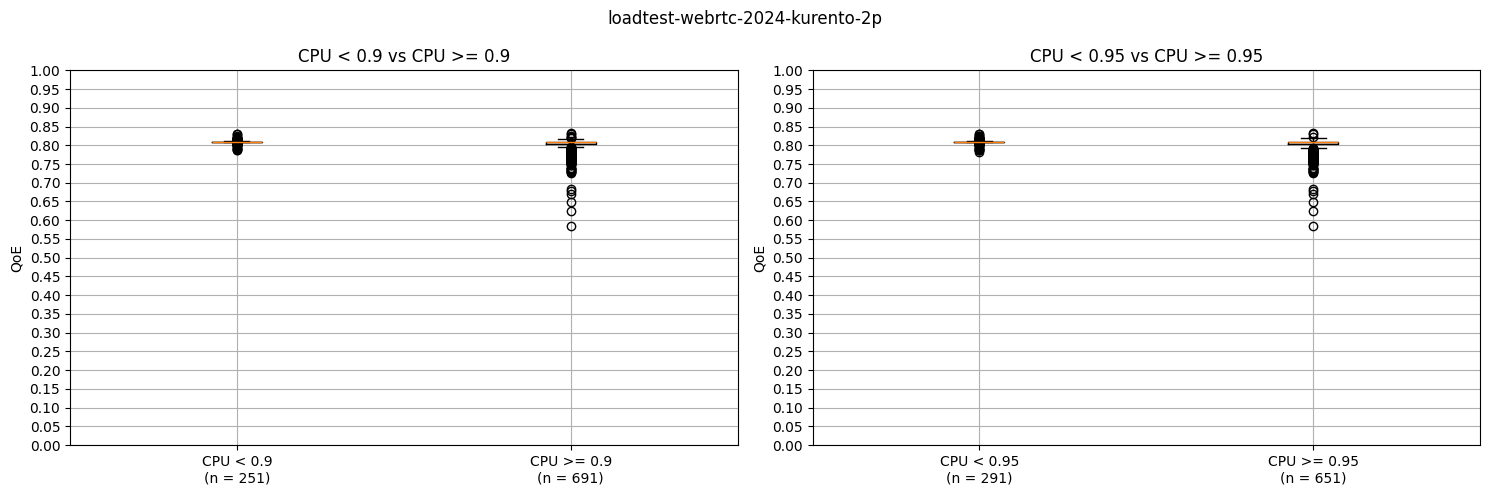

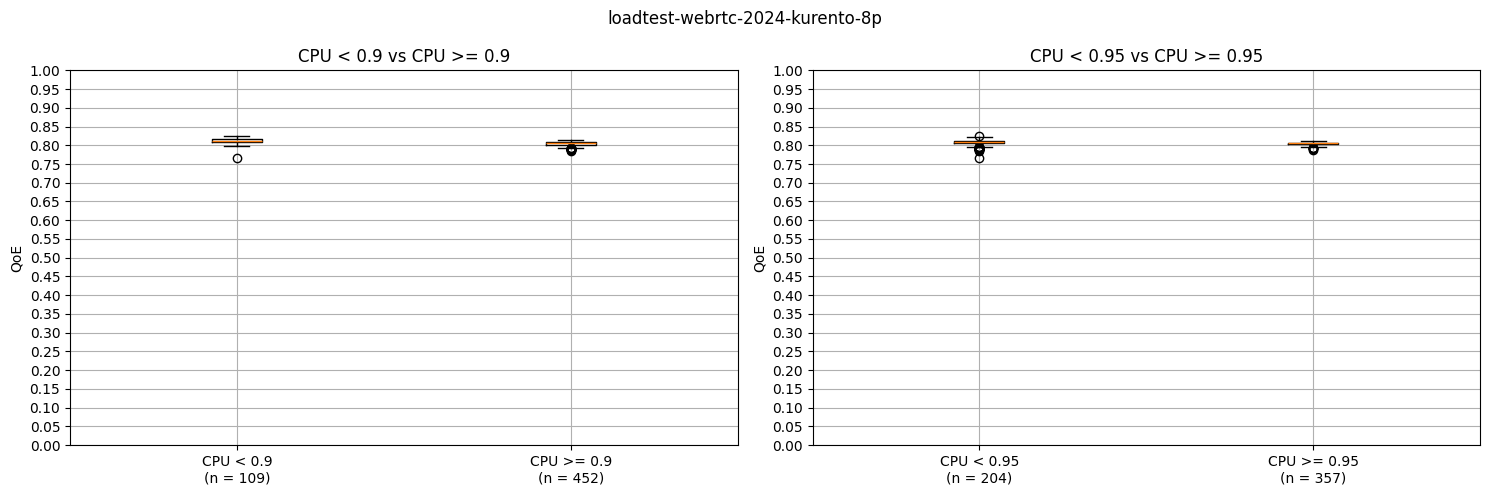

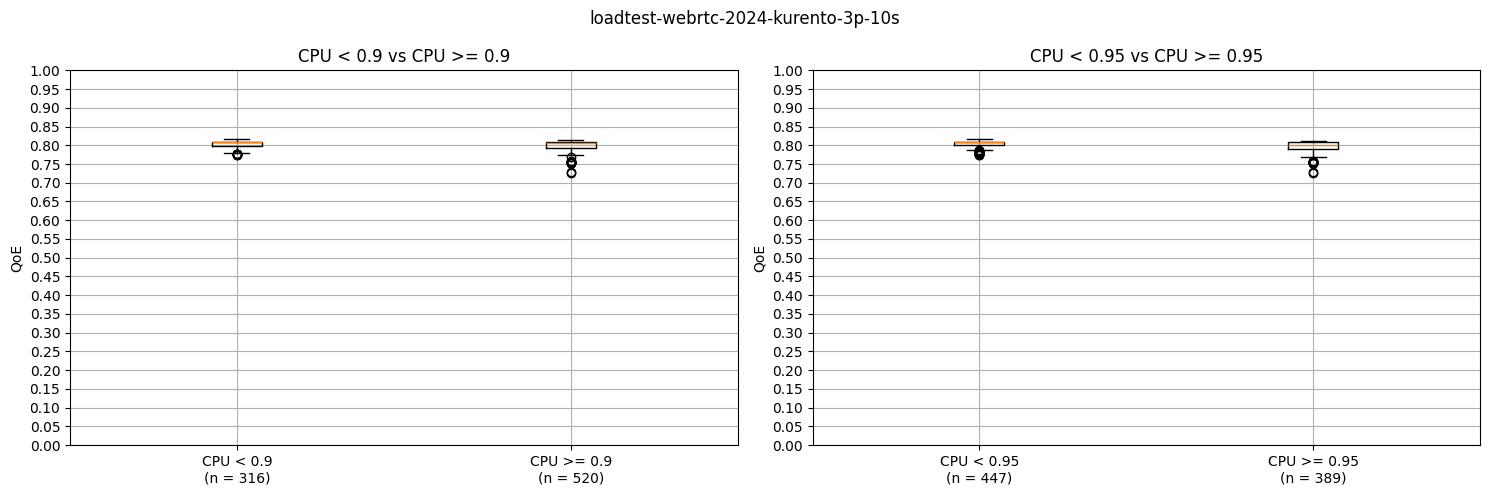

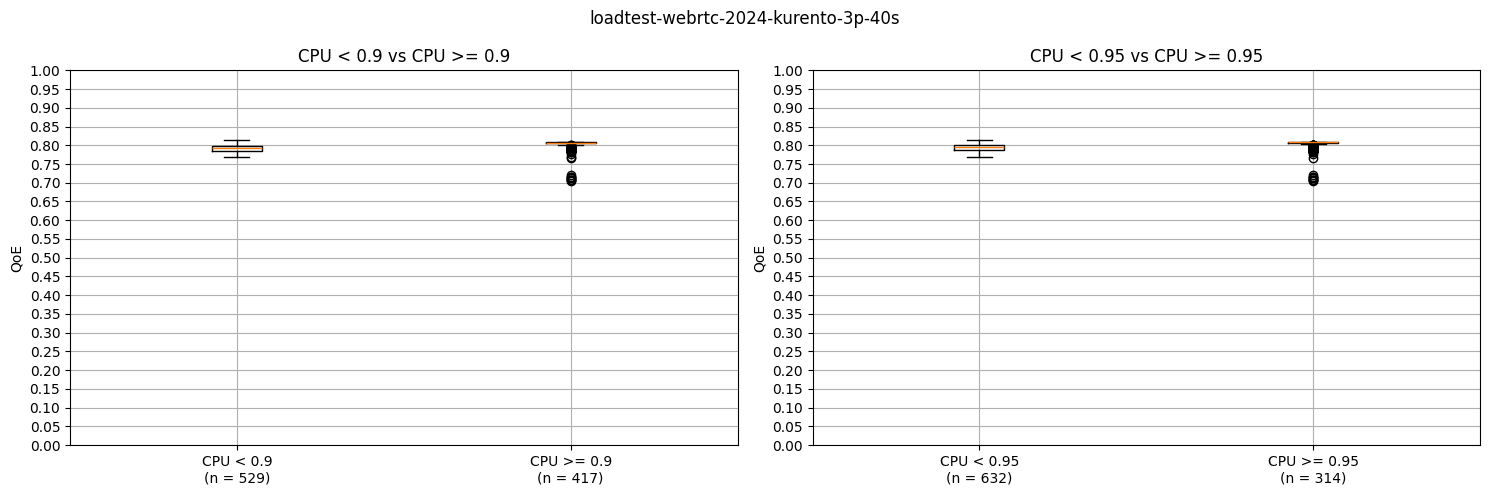

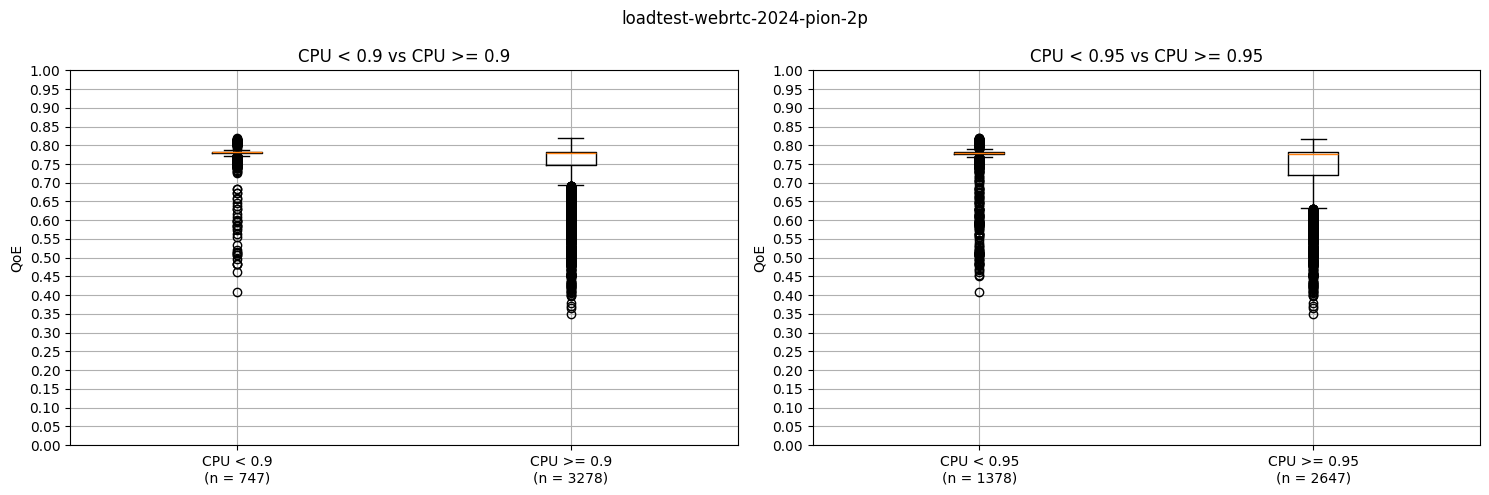

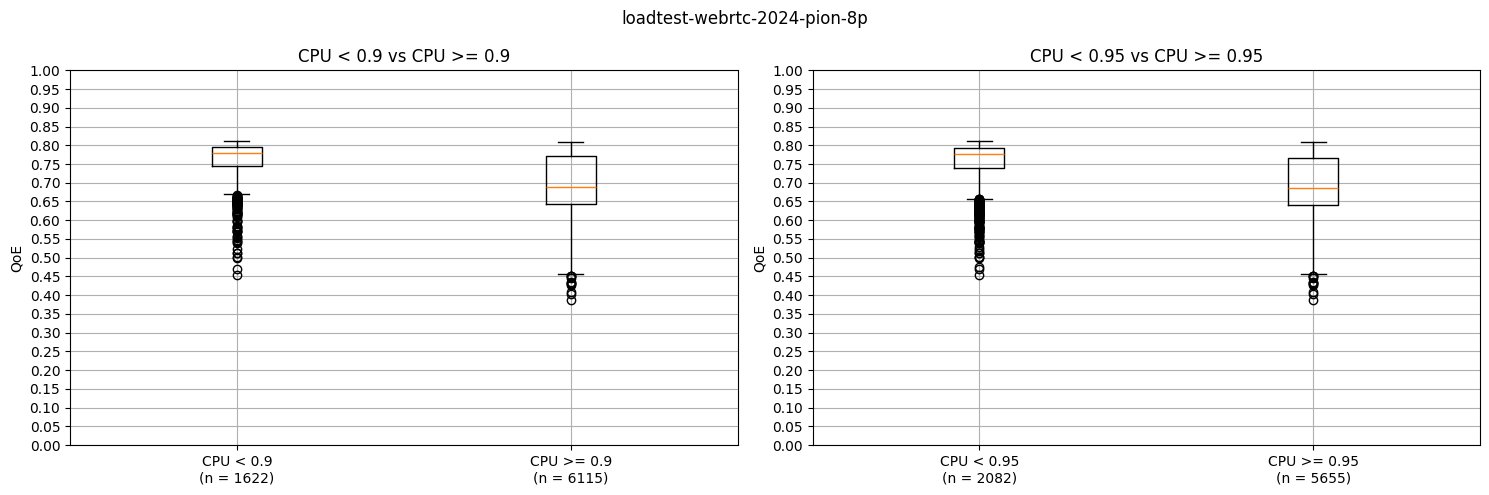

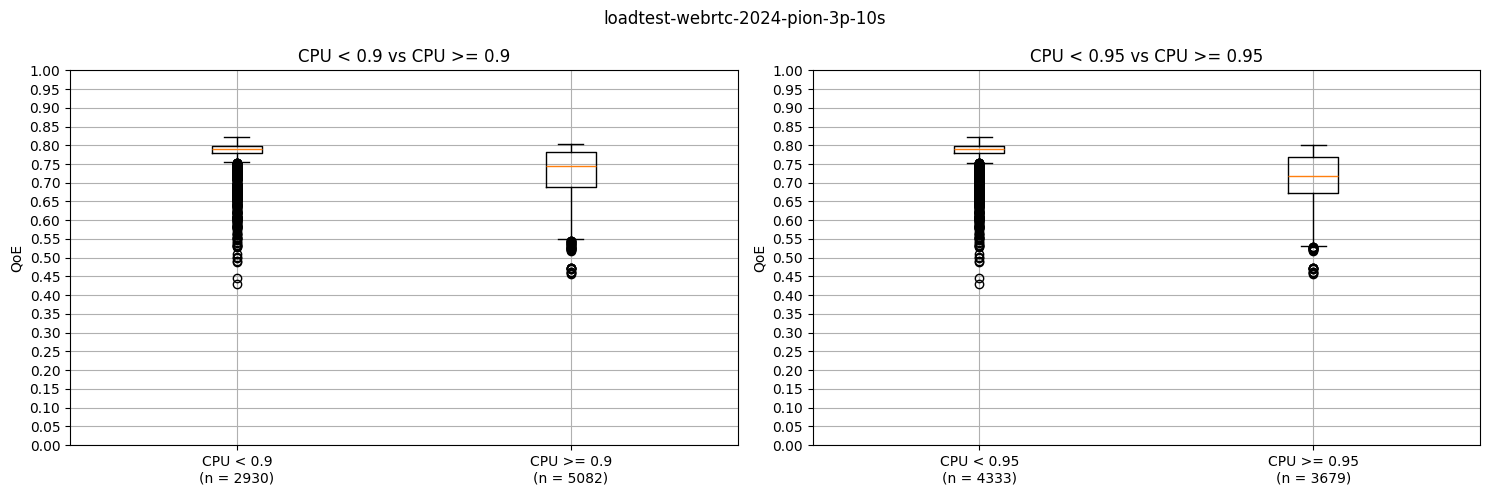

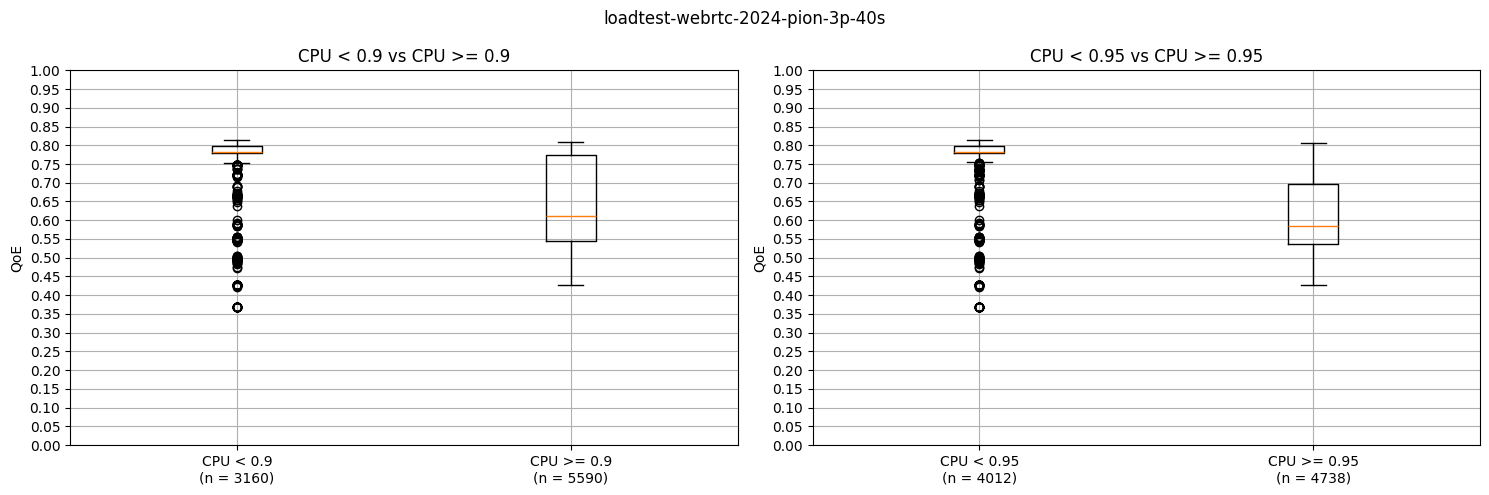

In [42]:
# Compare QoE values between different CPU thresholds
import warnings
# display("All cases together")
# cases = get_cases(connection_stats_global)
# comparisons = make_comparisons(cases)
# display(comparisons)
warnings.filterwarnings("ignore")
for index_list_name in index_list_names:
    connection_stats = connection_stats_global[
        connection_stats_global["index"] == index_list_name
    ]
    display(index_list_name)
    cases = get_cases(connection_stats)
    basics, comparisons, basics_clean, comparisons_clean = make_comparisons(cases, index_list_name)
    display(basics, basics_clean, comparisons, comparisons_clean)
warnings.filterwarnings("default")

In [42]:
# Compare connection start values when the connection start is followed by a connection success
def remove_no_connections(connection_stats):
    # remove all connectionStart that are not followed by a connectionSuccess for that full_user and attempt
    for i, row in connection_stats.iterrows():
        if row["type"] == "connectionStart":
            next_row = connection_stats[
                (connection_stats["full_user"] == row["full_user"])
                & (connection_stats["attempt"] == row["attempt"])
                & (connection_stats["start_time"] > row["start_time"])
            ]
            if next_row.empty or next_row.iloc[0]["type"] != "connectionSuccess":
                connection_stats = connection_stats.drop(i)
# Connection start of successful connections
con_stats = connection_stats_global.copy()
remove_no_connections(con_stats)
display("all cases")
cases = get_cases(con_stats, con_type="connectionStart", label="connection start duration (seconds)")
comparisons = make_comparisons(cases)
display(comparisons)
for index in index_list_names:
    connection_stats = connection_stats_global[connection_stats_global["index"] == index].copy()
    remove_no_connections(connection_stats)

    display(index)
    cases = get_cases(connection_stats, con_type="connectionStart", label="connection start duration (seconds)")
    comparisons = make_comparisons(cases, index)
    display(comparisons)

KeyError: '[1169] not found in axis'

In [ ]:
# For subscribers in tests with subscribers, compare connection start values when the connection start is followed by a connection success
def remove_no_connections_subs(connection_stats):
    # remove all connectionStart that are not followed by a connectionSuccess for that full_user and attempt
    for i, row in connection_stats.iterrows():
        if row["type"] == "connectionStart":
            if int(row["user"]) > 3:
                connection_stats = connection_stats.drop(i)
            else:
                next_row = connection_stats[
                    (connection_stats["full_user"] == row["full_user"])
                    & (connection_stats["attempt"] == row["attempt"])
                    & (connection_stats["start_time"] > row["start_time"])
                ]
                if next_row.empty or next_row.iloc[0]["type"] != "connectionSuccess":
                    connection_stats = connection_stats.drop(i)

connection_stats_subs = connection_stats_global[connection_stats_global["index"].str.contains("0s")].copy()
remove_no_connections_subs(connection_stats_subs)
display("all cases")
cases = get_cases(connection_stats_subs, con_type="connectionStart", label="connection start duration (seconds)")
comparisons = make_comparisons(cases)
display(comparisons)
for index in index_list_names:
    if "0s" in index:
        connection_stats = connection_stats_subs[connection_stats_subs["index"] == index].copy()
        remove_no_connections_subs(connection_stats)
        display(index)
        cases = get_cases(connection_stats, con_type="connectionStart", label="connection start duration (seconds)")
        comparisons = make_comparisons(cases, index)
        display(comparisons)


In [ ]:
# For publishers in tests with subscribers, compare connection start values when the connection start is followed by a connection success
def remove_no_connections_subs(connection_stats):
    # remove all connectionStart that are not followed by a connectionSuccess for that full_user and attempt
    for i, row in connection_stats.iterrows():
        if row["type"] == "connectionStart":
            if int(row["user"]) <= 3:
                connection_stats = connection_stats.drop(i)
            else:
                next_row = connection_stats[
                    (connection_stats["full_user"] == row["full_user"])
                    & (connection_stats["attempt"] == row["attempt"])
                    & (connection_stats["start_time"] > row["start_time"])
                ]
                if next_row.empty or next_row.iloc[0]["type"] != "connectionSuccess":
                    connection_stats = connection_stats.drop(i)

connection_stats_subs = connection_stats_global[connection_stats_global["index"].str.contains("0s")].copy()
remove_no_connections_subs(connection_stats_subs)
display("all cases")
cases = get_cases(connection_stats_subs, con_type="connectionStart", label="connection start duration (seconds)")
comparisons = make_comparisons(cases)
display(comparisons)
for index in index_list_names:
    if "0s" in index:
        connection_stats = connection_stats_subs[connection_stats_subs["index"] == index].copy()
        remove_no_connections_subs(connection_stats)
        display(index)
        cases = get_cases(connection_stats, con_type="connectionStart", label="connection start duration (seconds)")
        comparisons = make_comparisons(cases, index)
        display(comparisons)


In [ ]:
# 3 types of stats
# webrtcStats: jitter etc.
# inbound: qoe calculated via inbound metrics
# outbound: qoe calculated via outbound metrics
# at the moment we only care about webrtcStats

stats_dict = {
    "inbound": {},
    "outbound": {},
    "remote_inbound": {},
    "remote_outbound": {}
}

def process_stats(index_list_name):
    stats = get_index_data(index_list_name, "stats")
    for stat in stats:
        if 'stats' in stat:
            in_stats = stat['stats']
            for s in in_stats:
                # localUser = s['user']
                # localSession = s['session']
                if 'webrtcStats' in s:
                    webrtc_stats = s['webrtcStats']
                    for ws in webrtc_stats:
                        if ('event' in ws) and (ws['event'] == 'stats'):
                            yield ws

def add_remote_peer(data, remote_peer):
    for d in data:
        d['peerId'] = remote_peer


def separate_stats(index_list_name):
    def process_data(data, peer_id, direction):
        if data:
            add_remote_peer(data, peer_id)
            if index_list_name not in stats_dict[direction]:
                stats_dict[direction][index_list_name] = []
            stats_dict[direction][index_list_name].extend(data)

    for r in process_stats(index_list_name):
        remotePeer = r['peerId']
        if 'data' in r:
            d = r['data']
            local_audio = d['audio']
            local_video = d['video']
            remote_audio = d['remote']['audio']
            remote_video = d['remote']['video']

            process_data(local_audio['inbound'], remotePeer, 'inbound')
            process_data(local_audio['outbound'], remotePeer, 'outbound')
            process_data(local_video['inbound'], remotePeer, 'inbound')
            process_data(local_video['outbound'], remotePeer, 'outbound')
            process_data(remote_audio['inbound'], remotePeer, 'remote_inbound')
            process_data(remote_audio['outbound'], remotePeer, 'remote_outbound')
            process_data(remote_video['inbound'], remotePeer, 'remote_inbound')
            process_data(remote_video['outbound'], remotePeer, 'remote_outbound')

    for key in ['inbound', 'outbound', 'remote_inbound', 'remote_outbound']:
        stats_dict[key][index_list_name] = pd.DataFrame(stats_dict[key][index_list_name])
        stats_dict[key][index_list_name]['peerId'] = remotePeer

# Using ThreadPoolExecutor for concurrent processing
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = {executor.submit(separate_stats, index_list_name): index_list_name for index_list_name in index_list_names}
    for future in as_completed(futures):
        future.result()


In [ ]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_inbound = normalized_qos[normalized_qos["audio.inbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_inbound = normalized_inbound[["audio.inbound", "video.inbound", "remote.audio.outbound", "remote.video.outbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_inbound = expand_column(normalized_inbound, "audio.inbound")
video_inbound = expand_column(normalized_inbound, "video.inbound")
remote_audio_outbound = expand_column(normalized_inbound, "remote.audio.outbound")
remote_video_outbound = expand_column(normalized_inbound, "remote.video.outbound")

In [ ]:
plt_audio_inbound = audio_inbound.loc[:, ["timestamp", "packetRate", "bitrate"]]
plt_audio_inbound["timestamp"] = pd.to_datetime(plt_audio_inbound["timestamp"], unit="ms")

cpu = df_cpu_list[0]
cpu = cpu.drop(columns=["memory"]).dropna()
cpu["@timestamp"] = pd.to_datetime(cpu["@timestamp"], format="ISO8601").dt.tz_localize(None)

publishers_progression["timestamp"] = publishers_progression["timestamp"].dt.tz_localize(None)

# here min_ts is calculated as the minimum datetime of the 3 dataframes
# cpu are time aware while plt_audio_inbound is not
min_ts = pd.concat([cpu["@timestamp"], publishers_progression["timestamp"], plt_audio_inbound["timestamp"]]).min()

cpu_td = pd.DataFrame(columns=["timestamp", "cpu"])

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()
cpu_td["cpu"] = cpu["cpu"]

user_td = pd.DataFrame(columns=["timestamp", "publishers"])
user_td["timestamp"] = (publishers_progression["timestamp"] - min_ts).dt.total_seconds()
user_td["publishers"] = publishers_progression["number"]
user_td["label"] = publishers_progression["user"] + "-" + publishers_progression["session"]

plt_audio_inbound["timestamp"] = (plt_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--", alpha=0.2)
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
#ax.set_xlim(100, 110)
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Annotate users plot with offset to prevent overlap
texts = [ax2.text(x, y, label) for x, y, label in zip(user_td["timestamp"], user_td["publishers"], user_td["label"])]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black'))

# Commented out third y-axis for bitrate
# ax3 = ax.twinx()
# ax3.set_ylabel("bitrate")
# ax3.spines["right"].set_position(("axes", 1.075))
# ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["bitrate"], label="bitrate", linestyle="-")

fig.legend(loc='upper right')
fig.suptitle("Users over time")

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_audio_inbound["timestamp"], plt_audio_inbound["packetRate"], label="packet rate", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio rate over time")

In [ ]:
#remove all entries where audio.inbound is an empty list
def not_empty_list(x):
    return x != []
normalized_outbound = normalized_qos[normalized_qos["audio.outbound"].apply(not_empty_list)]

# keep only audio.inbound, video.inbound, remote.audio.outbound, remote.video.outbound and peerID
normalized_outbound = normalized_outbound[["audio.outbound", "video.outbound", "remote.audio.inbound", "remote.video.inbound", "peerId"]]

def expand_column(df, column_name):
    expanded = df[column_name].apply(pd.Series).stack().reset_index(level=1, drop=True)
    expanded = pd.json_normalize(expanded)
    return expanded

audio_outbound = expand_column(normalized_outbound, "audio.outbound")
video_outbound = expand_column(normalized_outbound, "video.outbound")
remote_audio_inbound = expand_column(normalized_outbound, "remote.audio.inbound")
remote_video_inbound = expand_column(normalized_outbound, "remote.video.inbound")

In [ ]:
plt_remote_audio_inbound = remote_audio_inbound.loc[:, ["timestamp", "roundTripTime"]]
plt_remote_audio_inbound["timestamp"] = pd.to_datetime(plt_remote_audio_inbound["timestamp"], unit="ms")

min_ts = pd.concat([cpu["@timestamp"], user_join["@timestamp"], plt_remote_audio_inbound["timestamp"]]).min()

cpu_td["timestamp"] = (cpu["@timestamp"] - min_ts).dt.total_seconds()

user_td["timestamp"] = (user_join["@timestamp"] - min_ts).dt.total_seconds()

plt_remote_audio_inbound["timestamp"] = (plt_remote_audio_inbound["timestamp"] - min_ts).dt.total_seconds()

In [ ]:
plt.rcParams["figure.figsize"] = [25, 10]

fig, ax = plt.subplots()
ax.plot(cpu_td["timestamp"], cpu_td["cpu"], label="CPU usage", color="black", marker="o", linestyle="--")
ax.set_xlabel("time")
ax.set_ylabel("CPU usage (%)")
ax.grid()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax2 = ax.twinx()
ax2.set_ylabel("users")
ax2.spines["right"].set_position(("axes", 1.025))
ax2.plot(user_td["timestamp"], user_td["publishers"], label="users", color="red", marker="o", linestyle="-")
ax3 = ax.twinx()
ax3.set_ylabel("bitrate")
ax3.spines["right"].set_position(("axes", 1.075))
ax3.plot(plt_remote_audio_inbound["timestamp"], plt_remote_audio_inbound["roundTripTime"], label="roundTripTime", linestyle="-")

fig.legend()
fig.suptitle("Inbound audio RTT (s) over time")

ax3.axhline(y=0.1, color="green", linestyle="-", label="good rtt")
ax3.axhline(y=0.2, color="orange", linestyle="-", label="mediocre rtt")

In [ ]:
# list of directories in stats/
dirs = os.listdir("stats/")
# read all events.json in each subdir
events = []
for i, dir in enumerate(dirs):
    subdirs = os.listdir(f"stats/{dir}")
    for subdir in subdirs:
        with open(f"stats/{dir}/{subdir}/events.json") as f:
            events.extend(json.load(f))

In [ ]:
connection_start_fn = lambda x: (x['event'] == 'connectionStart')
connection = list(filter(connection_start_fn, events))

connection_df = pd.DataFrame(columns=["user", "session", "time to connect (s)", "connection start time", "stream created time"])
for i, conn in enumerate(connection):
    participant = conn['participant']
    session = conn['session']
    connection_start = conn['timestamp']
    stream_created = list(filter(lambda x: (x['event'] == 'streamCreated') and (x['connection'] == 'local') and (x['participant'] == participant) and (x['session'] == session), events))
    if len(stream_created) > 1:
        print(f"More than one stream created for connection {participant}-{session}")
    if len(stream_created) == 0:
        print(f"No stream created for connection {participant}-{session}")
        continue
    created_time = stream_created[0]['timestamp']
    # convert to datetime
    connection_start = datetime.strptime(connection_start, '%Y-%m-%dT%H:%M:%S.%fZ')
    created_time = datetime.strptime(created_time, '%Y-%m-%dT%H:%M:%S.%fZ')
    time_diff = (created_time - connection_start).total_seconds()
    connection_df.loc[i] = [participant, session, time_diff, connection_start, created_time]

#display(connection_df)

#bar chart of time to connect
plt.rcParams["figure.figsize"] = [25, 10]
fig, ax = plt.subplots()
ax.bar(connection_df["user"] + "-"+ connection_df["session"], connection_df["time to connect (s)"])
ax.set_xlabel("user-session")
ax.set_ylabel("time to connect (s)")
# rotate x labels
plt.xticks(rotation=90)

ax.grid()
fig.suptitle("Time to publish for each connection (s)")